In [253]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class NeuralNetwork:

    @staticmethod
    def sigma(x):
        return 1 / (np.exp(-x) + 1)

    @staticmethod
    def sigma_deriv(x):
        sig = NeuralNetwork.sigma(x)
        deriv = sig * (1 - sig)
        return deriv

    @staticmethod
    def softmax(x):
        # softmax function ---------
        t = np.exp(x - np.max(x))
        return t / np.sum(t, axis=1, keepdims=True)

    @staticmethod
    def get_activation_function(name):
        if name == 'sigma':
            return NeuralNetwork.sigma
        elif name == 'linear':
            return lambda x: x
        elif name == 'softmax':
            return NeuralNetwork.softmax
        elif name == 'tanh':
            return np.tanh
        elif name == 'relu':
            return lambda x: np.maximum(0, x)

    @staticmethod
    def get_activation_derivative(name):
        if name == 'sigma':
            return NeuralNetwork.sigma_deriv
        elif name == 'linear':
            return lambda x: np.ones_like(x)
        elif name == 'softmax':
            # jacobian of softmax - unused -------
            def softmax_deriv(x):
                value = NeuralNetwork.softmax(x)
                SM = value.reshape((-1, 1))
                jac = np.diagflat(value) - np.dot(SM, SM.T)
                return jac

            return softmax_deriv
        elif name == 'tanh':
            return lambda x: 1 - np.tanh(x)**2
        elif name == 'relu':
            return lambda x: x > 0


    @staticmethod
    def get_loss_function(name):
        if name == 'mse':
            return lambda x_pred, x: np.linalg.norm(x_pred - x)
        elif name == 'mae':
            return lambda x_pred, x: np.sum(np.abs(x_pred - x))
        elif name == 'crossentropy':
            return lambda x_pred, x: -np.sum(x*np.log(x_pred))

    @staticmethod
    def get_loss_derivative(name):
        # currently unused
        if name == 'mse':
            return lambda x_pred, x: (x_pred - x)
        if name == 'mae':
            return lambda x_pred, x: np.sign(x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: x*(-1/x_pred)

    class Layer:
        def __init__(self, input_width, layer_width, activation_function):
            # self.weights = np.random.uniform(0, 1, (input_width + 1, layer_width))
            self.weights = np.random.normal(0, 1, (input_width + 1, layer_width))
            self.activation_function = activation_function

        def predict(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            return activation_function(np.dot(x, self.weights))

        def feedforward_step(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            activation = np.dot(x, self.weights)
            response = activation_function(activation)
            return response, activation

    def __init__(self, input_width, output_width, activation_function='sigma', loss_function='mse', bias_exists=True, seed=None, verbose=True):
        ###
        # create a new nn object. activation_function specifies activation used on hidden layers
        # loss_function affects loss printed to console
        ###
        self.input_width = input_width
        self.output_width = output_width
        self.layers = []
        self.activation_function = activation_function
        self.loss_function = NeuralNetwork.get_loss_function(loss_function)
        self.loss_derivative = NeuralNetwork.get_loss_derivative(loss_function)
        self.bias_exists = bias_exists
        self.seed = seed
        self.verbose = verbose

    def add_layer(self, layer_width):
        ###
        # add a hidden layer with specified number of neurons
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, layer_width, self.activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], layer_width, self.activation_function))


    def predict(self, x):
        ###
        # predict responses on new data
        ###
        values = np.copy(x)
        for layer in self.layers:
            values = np.hstack((values, np.ones((values.shape[0], 1)) if self.bias_exists else np.zeros((values.shape[0], 1))))
            values = layer.predict(values)
        return values

    def create_output_layer(self, activation_function='linear'):
        ###
        # create output layer with specified activation function. Use after adding all hidden layers and before training
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, self.output_width, activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], self.output_width, activation_function))

    def feedforward(self, x):
        response = np.copy(x)
        response = response.reshape(1, -1)
        response = np.hstack((response, np.ones((response.shape[0], 1))))
        response_s = [response]
        activation_s = []
        for i in range(len(self.layers) - 1):
            response, activation = self.layers[i].feedforward_step(response_s[i])
            activation_s.append(activation)
            response = response.reshape(1, -1)
            response = np.hstack((response, np.ones((response.shape[0], 1))))
            response_s.append(response)
        response, activation = self.layers[-1].feedforward_step(response_s[-1])
        activation_s.append(activation)
        response = response.reshape(1, -1)
        response_s.append(response)
        return (response_s, activation_s)

    def backpropagation(self, x, y, r_s, a_s):
        e_s = [None] * len(self.layers)

        ###
        # derivative of loss function in respect to final layer weights
        # assuming loss is crossentropy and output layer is softmax
        # formula is the same as in the case of linear outputs and mse
        ###
        e_s[-1] = a_s[-1] - y

        for i in reversed(range(1, len(e_s))):
            unbiased_weights = self.layers[i].weights[0:(self.layers[i].weights.shape[0] - 1), :]
            e_s[i-1] = NeuralNetwork.get_activation_derivative(self.layers[i-1].activation_function)(a_s[i-1])*(e_s[i].dot(unbiased_weights.T))
        gradient = [r_s[j].T.dot(e_s[j]) for j in range(0, len(self.layers))]
        return gradient

    def train(self, x, y, batch_size=10, epochs=100, lr=0.01, method='basic', method_param=0.0):
        ###
        # train network. method can be 'basic', 'momentum' or 'rmsprop'.
        # method_param specifies lambda in momentum or beta in rmsprop
        ###
        if self.seed is not None:
            np.random.seed(self.seed)
        errors = []
        eps = 1e-8
        momentum = [np.zeros(layer.weights.shape) for layer in self.layers]
        for e in range(epochs):
            permutation = np.random.permutation(y.shape[0])
            x = x[permutation, :]
            y = y[permutation, :]
            i = 0
            while i < y.shape[0]:
                deltas = [np.zeros(layer.weights.shape) for layer in self.layers]
                x_batch = x[i:i + batch_size, :]
                y_batch = y[i:i + batch_size, :]
                i = i + batch_size
                for j in range(0, y_batch.shape[0]):
                    r_s, a_s = self.feedforward(x_batch[j, :])
                    gradient = self.backpropagation(x_batch[j, :], y_batch[j, :], r_s, a_s)
                    for k in range(0, len(deltas)):
                        deltas[k] = deltas[k] - gradient[k]

                if method == 'momentum':
                    momentum = [delta + method_param * mom for mom, delta in zip(momentum, deltas)]
                elif method == 'rmsprop':
                    momentum = [method_param * mom + (1 - method_param)*np.square(delta) for mom, delta in zip(momentum, deltas)]

                for j in range(0, len(deltas)):
                    if method == 'momentum':
                        self.layers[j].weights = self.layers[j].weights + lr*momentum[j]
                    elif method == 'rmsprop':
                        self.layers[j].weights = self.layers[j].weights + lr * (deltas[j] / (np.sqrt(momentum[j]) + eps))
                    else:
                        self.layers[j].weights = self.layers[j].weights + lr*deltas[j]

                error = self.loss_function(self.predict(x_batch), y_batch)
                if self.verbose:
                    print("loss on batch = {}".format(error))
                errors.append(error)
        return errors


# TESTS ------------------------------------------------------------------------
# set path to dataset folders
classification = "projekt1/classification/"
regression = "projekt1/regression/"

# side functions

def nnerrors(inputw, outputw, activation, X, y, layers1, layers2, layers3, output_activation='linear', loss='mse', epochs=4):
    nn1 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers1:
        nn1.add_layer(layer)
    nn1.create_output_layer(output_activation)
    nn2 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers2:
        nn2.add_layer(layer)
    nn2.create_output_layer(output_activation)
    nn3 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers3:
        nn3.add_layer(layer)
    nn3.create_output_layer(output_activation)

    errors1 = nn1.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors2 = nn2.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors3 = nn3.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)

    return [errors1, errors2, errors3]


def make_plots(inputw, outputw, X, y, layers1, layers2, layers3, output_activation, loss, label1, label2, label3, suptitle, ylim=(0, 20), epochs=4):
    np.random.seed(42)
    sigma_error = nnerrors(inputw, outputw, 'sigma', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    tanh_error = nnerrors(inputw, outputw, 'tanh', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    relu_error = nnerrors(inputw, outputw, 'relu', X, y, layers1, layers2, layers3, output_activation, loss, epochs)

    x_err = range(len(sigma_error[0]))

    fig, axis = plt.subplots(1, 3, figsize=(10,5))
    plt.setp(axis, ylim=ylim)
    axis[0].plot(x_err, sigma_error[0], label=label1)
    axis[0].plot(x_err, sigma_error[1], label=label2)
    axis[0].plot(x_err, sigma_error[2], label=label3)
    axis[0].set_title('sigma')
    axis[0].set_ylabel(loss)
    axis[1].plot(x_err, tanh_error[0])
    axis[1].plot(x_err, tanh_error[1])
    axis[1].plot(x_err, tanh_error[2])
    axis[1].set_title('tanh')
    axis[2].plot(x_err, relu_error[0])
    axis[2].plot(x_err, relu_error[1])
    axis[2].plot(x_err, relu_error[2])
    axis[2].set_title('relu')
    fig.legend()
    fig.suptitle(suptitle)
    fig.show()

In [134]:
f = open(classification + "data.three_gauss.train.1000.csv")
gauss3train = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_train = gauss3train[:, 0:2]
y_train = gauss3train[:, 2]
y_train = y_train.reshape(-1, 1)
encoder_gauss3 = OneHotEncoder(sparse=False)
y_gauss3train = encoder_gauss3.fit_transform(y_train)
X_gauss3train = X_train

f = open(classification + "data.three_gauss.test.1000.csv")
gauss3test = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_test = gauss3test[:, 0:2]
y_test = gauss3test[:, 2]
y_test = y_test.reshape(-1, 1)
y_gauss3test = encoder_gauss3.transform(y_test)
X_gauss3test = X_test


In [135]:
y_gauss3train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

loss on batch = 1315.9256161811454
loss on batch = 1184.3599066620118
loss on batch = 982.2583406484796
loss on batch = 887.9095855435913
loss on batch = 810.6580563415098
loss on batch = 718.2246748193818
loss on batch = 668.3472178022566
loss on batch = 622.5202171394513
loss on batch = 586.8742113690541
loss on batch = 559.4438134684247
loss on batch = 543.9240735063977
loss on batch = 541.7885593843018
loss on batch = 538.2429092535139
loss on batch = 539.7053344944242
loss on batch = 538.1553498077835
loss on batch = 537.3852713902163
loss on batch = 536.5332967239749
loss on batch = 529.3311549646568
loss on batch = 532.436304480181
loss on batch = 527.7532297217925
loss on batch = 523.0084449659341
loss on batch = 517.2045306787447
loss on batch = 516.9335646953903
loss on batch = 513.1401572250104
loss on batch = 513.6560107679752
loss on batch = 504.25252928247073
loss on batch = 502.6642354578779
loss on batch = 498.960805522825
loss on batch = 494.3167410022992
loss on batch

/home/pysiakk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


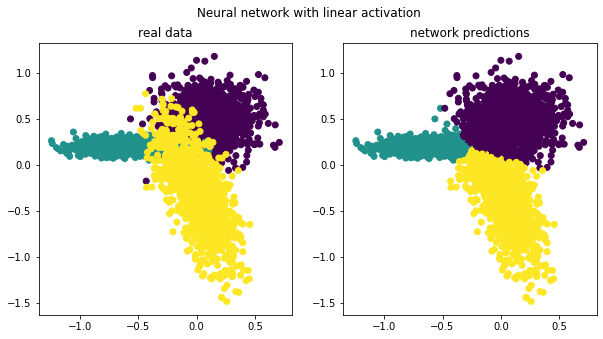

In [5]:
nn = NeuralNetwork(2, 3, loss_function='crossentropy')

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer('softmax')
nn.errors = nn.train(X_gauss3train, y_gauss3train, epochs=20, batch_size=500, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_gauss3test)

# Plot example
y = encoder_gauss3.inverse_transform(y_gauss3test)
y_pred = encoder_gauss3.inverse_transform(pred)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

axis[0].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y.flatten())
axis[0].set_title('real data')
axis[1].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y_pred.flatten())
axis[1].set_title('network predictions')
fig.suptitle('Neural network with linear activation')
fig.show()

In [52]:
f = open(regression + 'data.activation.train.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_train = X.reshape(-1,1)
y_activation_train = y.reshape(-1,1)


f = open(regression + 'data.activation.test.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_test = X.reshape(-1,1)
y_activation_test = y.reshape(-1,1)


In [61]:
nn = NeuralNetwork(1, 1)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_activation_train, y_activation_train, epochs=5, batch_size=100, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_activation_test)

# Plot example


plt.scatter(X_activation_test.flatten(), y_activation_test.flatten(), label='real data')
plt.scatter(X_activation_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()


NameError: name 'X_activation_train' is not defined

## Testing different activation functions

### Regression

In [47]:
data = pd.read_csv("projekt1/regression/data.activation.train.10000.csv")
X_train = np.array(data.iloc[:,:1])
y_train = np.array(data.iloc[:,1:])
data = pd.read_csv("projekt1/regression/data.activation.test.10000.csv")
X_test = np.array(data.iloc[:,:1])
y_test = np.array(data.iloc[:,1:])
X_test = (X_test - np.mean(X_train)) / np.std(X_train)
y_test = (y_test - np.mean(y_train)) / np.std(y_train)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
y_train = (y_train - np.mean(y_train)) / np.std(y_train)
print(X_train)
print(y_train)

[[-0.61804391]
 [ 0.63565033]
 [ 1.10413489]
 ...
 [-0.60777057]
 [-1.19618858]
 [-0.18647261]]
[[-0.45938957]
 [ 0.83263424]
 [ 0.95225293]
 ...
 [-0.44217055]
 [-1.40181267]
 [ 0.19361084]]


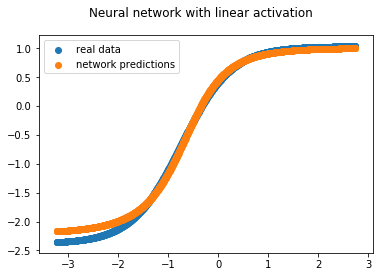

MSE: 0.007979045500215633


In [81]:
nn = NeuralNetwork(1, 1, activation_function="sigma", seed=123, verbose=False)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

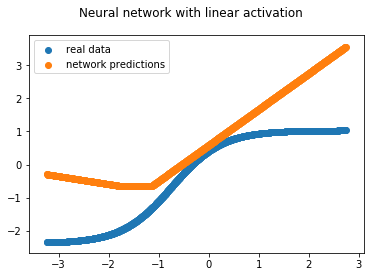

MSE: 1.797465909235926


In [86]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123, verbose=False)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

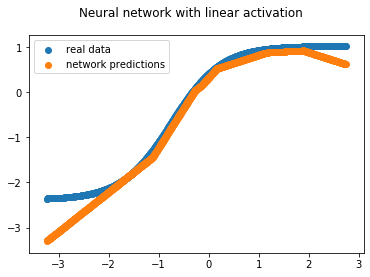

MSE: 0.07387982193935981


In [97]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123, verbose=False)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

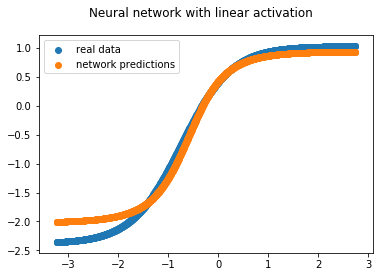

MSE: 0.027160724900499388


In [99]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=False)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

### Classification

In [146]:
data = pd.read_csv("projekt1/classification/data.three_gauss.train.1000.csv")
X_train = np.array(data.iloc[:,:2])
y_train = np.array(data.iloc[:,2:])
data = pd.read_csv("projekt1/classification/data.three_gauss.test.1000.csv")
X_test = np.array(data.iloc[:,:2])
y_test = np.array(data.iloc[:,2:])
X_test = (X_test - np.mean(X_train)) / np.std(X_train)
# y_test = (y_test - np.mean(y_train)) / np.std(y_train)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
# y_train = (y_train - np.mean(y_train)) / np.std(y_train)
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train)
y_test = ohe.transform(y_test)
print(X_train)
print(y_train)

[[ 0.51839174  1.12942924]
 [ 0.54453533  2.16957697]
 [ 0.93212147  0.44372788]
 ...
 [-0.50272867  0.56045434]
 [ 0.17286364 -0.45026591]
 [ 0.49450439 -2.00396316]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


loss on batch = 12.243381858151139
loss on batch = 12.314381701569138
loss on batch = 12.198100712647445
loss on batch = 11.973353232043898
loss on batch = 11.358646403049745
loss on batch = 11.569764468874002
loss on batch = 12.067991136749216
loss on batch = 11.634817891371332
loss on batch = 12.524764167908364
loss on batch = 12.476121040650387
loss on batch = 13.172775466548092
loss on batch = 12.432997049417354
loss on batch = 13.016487378365058
loss on batch = 12.001592809138057
loss on batch = 11.581788591358986
loss on batch = 12.326916034175316
loss on batch = 11.918535934197594
loss on batch = 12.579636952314207
loss on batch = 12.1079644874311
loss on batch = 11.96842783764953
loss on batch = 11.90778624505669
loss on batch = 11.435151846898426
loss on batch = 12.344670046342648
loss on batch = 12.196280384358323
loss on batch = 12.063854419737927
loss on batch = 11.742961492918266
loss on batch = 11.780031957763624
loss on batch = 12.285384295484834
loss on batch = 11.89761

loss on batch = 10.48020153594666
loss on batch = 10.34015595232831
loss on batch = 10.446320828522417
loss on batch = 10.583440458776792
loss on batch = 10.484436069963625
loss on batch = 10.660909762849846
loss on batch = 10.42184709188453
loss on batch = 10.510398274594994
loss on batch = 10.43155877326122
loss on batch = 10.692130429414068
loss on batch = 10.2558175282351
loss on batch = 10.196174863929338
loss on batch = 10.484254936747773
loss on batch = 10.439520594454214
loss on batch = 10.37490164993045
loss on batch = 9.909381245216034
loss on batch = 10.538554815095404
loss on batch = 10.439010639940118
loss on batch = 10.322274558539739
loss on batch = 10.713105902583848
loss on batch = 10.112739907617474
loss on batch = 10.555320133491835
loss on batch = 10.508927271660323
loss on batch = 10.549589900304964
loss on batch = 10.655353435026267
loss on batch = 10.195307108370416
loss on batch = 10.539471727881798
loss on batch = 10.089503316183936
loss on batch = 10.329323771

loss on batch = 8.788343582561671
loss on batch = 9.66433381738164
loss on batch = 9.224131020787862
loss on batch = 9.98310842887643
loss on batch = 9.5607735473195
loss on batch = 9.220172952428078
loss on batch = 9.434390012439083
loss on batch = 8.457570592408537
loss on batch = 9.912435420026735
loss on batch = 9.990988408186013
loss on batch = 9.400447125957257
loss on batch = 9.414579237386132
loss on batch = 9.815113098019163
loss on batch = 9.273860228999997
loss on batch = 8.917322053788045
loss on batch = 9.24399605939938
loss on batch = 9.448793077191029
loss on batch = 9.094404205936776
loss on batch = 8.931198860132652
loss on batch = 9.038808050759144
loss on batch = 9.192449141242857
loss on batch = 9.884831349129819
loss on batch = 9.205350895711282
loss on batch = 9.784010589654262
loss on batch = 9.570072928777552
loss on batch = 9.34965360929054
loss on batch = 9.21972251498031
loss on batch = 8.970084468839445
loss on batch = 10.102997126314273
loss on batch = 10.4

loss on batch = 8.175364290881033
loss on batch = 7.464729334105258
loss on batch = 9.268636987320678
loss on batch = 7.279634672018323
loss on batch = 7.937113116863518
loss on batch = 8.912604031821168
loss on batch = 7.975904038639893
loss on batch = 8.45918774057678
loss on batch = 8.455128874742794
loss on batch = 8.101103889985165
loss on batch = 7.413956252884228
loss on batch = 7.731951321225301
loss on batch = 8.648677514391105
loss on batch = 7.474271823051428
loss on batch = 8.637728802095467
loss on batch = 9.694171331156822
loss on batch = 9.00879262406464
loss on batch = 8.15206783983069
loss on batch = 8.297947294386788
loss on batch = 8.324161703863743
loss on batch = 8.900894619262628
loss on batch = 8.708560722238404
loss on batch = 8.808427040605803
loss on batch = 7.742985722093433
loss on batch = 8.895830033664957
loss on batch = 8.255212474811751
loss on batch = 8.7172381572898
loss on batch = 7.2664970178838475
loss on batch = 7.471843187625508
loss on batch = 8.

loss on batch = 7.609222966469847
loss on batch = 7.506658447898014
loss on batch = 8.976807480053695
loss on batch = 8.10555383022337
loss on batch = 8.607670851219057
loss on batch = 7.600082774311332
loss on batch = 8.843621909161218
loss on batch = 7.894309828573389
loss on batch = 9.543688564878915
loss on batch = 7.89118251344302
loss on batch = 7.378336598359316
loss on batch = 7.745996514983557
loss on batch = 8.303101558972028
loss on batch = 7.692070245824564
loss on batch = 7.611260801550354
loss on batch = 8.650014228093633
loss on batch = 9.714940869555534
loss on batch = 7.930541638008178
loss on batch = 7.69514383574437
loss on batch = 6.560160418245235
loss on batch = 7.943392464677226
loss on batch = 7.071825457885161
loss on batch = 7.327642545576283
loss on batch = 8.510114661961897
loss on batch = 8.067678875124228
loss on batch = 8.03947949882473
loss on batch = 7.436109833083949
loss on batch = 7.04879487286285
loss on batch = 8.093012184634446
loss on batch = 9.1

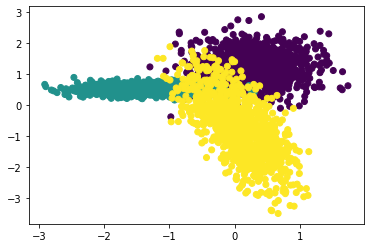

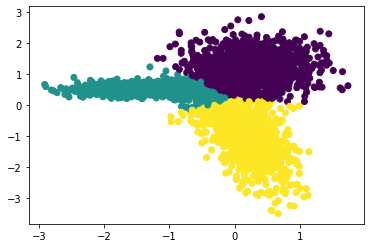

Acc: 0.9116666666666666


In [165]:
nn = NeuralNetwork(2, 3, activation_function="sigma", loss_function='crossentropy', seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer("softmax")
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(y_test, axis=1).flatten())
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(pred, axis=1).flatten())
plt.show()

print("Acc: " + str(np.mean((np.argmax(y_test, axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

loss on batch = 42.10673655994109
loss on batch = 29.997905659273624
loss on batch = 10.572722128915405
loss on batch = 10.909949939304461
loss on batch = 10.605563820596036
loss on batch = 10.237750790091242
loss on batch = 11.601280515880209
loss on batch = 10.09531369407038
loss on batch = 11.919668548144331
loss on batch = 11.783851554589729
loss on batch = 11.326714290324885
loss on batch = 10.815972380928203
loss on batch = 10.848754075333153
loss on batch = 10.648953750457743
loss on batch = 10.766067317301376
loss on batch = 9.426280073208103
loss on batch = 10.410517614689807
loss on batch = 10.776938925153392
loss on batch = 9.625333047886098
loss on batch = 9.6874786140628
loss on batch = 10.274282991081964
loss on batch = 9.302151653454615
loss on batch = 12.004445947329572
loss on batch = 10.001002073899878
loss on batch = 9.937981332776056
loss on batch = 9.607306436507367
loss on batch = 10.515246598645449
loss on batch = 9.971915192310759
loss on batch = 9.2327401283228

loss on batch = 8.757530485940109
loss on batch = 7.373382312680557
loss on batch = 8.33078070588612
loss on batch = 8.190580839015672
loss on batch = 8.10170497216941
loss on batch = 9.482408446614471
loss on batch = 8.598941486394722
loss on batch = 8.673647018462175
loss on batch = 7.851671230076873
loss on batch = 9.197235677682427
loss on batch = 8.166753860563265
loss on batch = 7.451382376719235
loss on batch = 8.083474061600564
loss on batch = 8.598498234109506
loss on batch = 8.603699377010038
loss on batch = 9.362027231002525
loss on batch = 8.234715975777315
loss on batch = 8.767685702064835
loss on batch = 8.478834084806412
loss on batch = 8.467837563484983
loss on batch = 8.710017935154468
loss on batch = 8.828182414676668
loss on batch = 8.528679083938048
loss on batch = 9.093933411565038
loss on batch = 7.972653257133297
loss on batch = 9.433874466514123
loss on batch = 9.566149515158155
loss on batch = 8.184504098865105
loss on batch = 8.289936658238
loss on batch = 9.0

loss on batch = 9.064737324119688
loss on batch = 9.819506575840379
loss on batch = 7.815188200715537
loss on batch = 7.808612018250459
loss on batch = 8.661271286406883
loss on batch = 8.674545922774865
loss on batch = 8.182313941180915
loss on batch = 7.530913134268907
loss on batch = 7.8804033361703265
loss on batch = 7.279643256961872
loss on batch = 8.343104421284279
loss on batch = 8.685668727958596
loss on batch = 7.979344583121934
loss on batch = 7.723414091180622
loss on batch = 7.511783902859291
loss on batch = 9.236242369520005
loss on batch = 8.552355482838003
loss on batch = 8.265047893721142
loss on batch = 8.489698651135926
loss on batch = 9.054511952302875
loss on batch = 8.885417254887521
loss on batch = 7.932497561002952
loss on batch = 8.212271289067274
loss on batch = 7.179973472102471
loss on batch = 7.872410906572315
loss on batch = 9.274998916162426
loss on batch = 8.427855591604063
loss on batch = 7.682962001816183
loss on batch = 7.784439609049849
loss on batch

loss on batch = 7.591489911236838
loss on batch = 7.6619098634438485
loss on batch = 7.0985289800607045
loss on batch = 7.583685351786686
loss on batch = 7.294399693807953
loss on batch = 8.995013558919052
loss on batch = 6.724399222232152
loss on batch = 8.98037815320556
loss on batch = 7.76237297231468
loss on batch = 7.038366512560277
loss on batch = 8.781870342937378
loss on batch = 8.223113852542818
loss on batch = 7.889418033087673
loss on batch = 8.614768824271096
loss on batch = 8.41073667533644
loss on batch = 8.131252480802553
loss on batch = 8.725796447723637
loss on batch = 6.756968802366841
loss on batch = 7.362354092759167
loss on batch = 9.128047522349139
loss on batch = 8.47222745201377
loss on batch = 8.112208589032086
loss on batch = 8.549453684291203
loss on batch = 8.71103731949825
loss on batch = 8.560362845883699
loss on batch = 8.314869546884157
loss on batch = 7.837091285432253
loss on batch = 9.00635813327442
loss on batch = 6.624239100894396
loss on batch = 7.

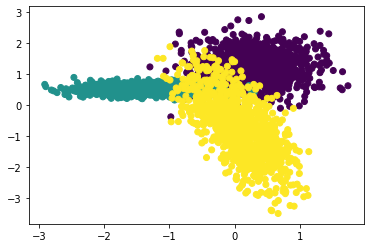

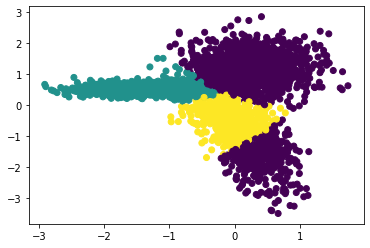

Acc: 0.8113333333333334


In [166]:
nn = NeuralNetwork(2, 3, activation_function="relu", loss_function='crossentropy', seed=123, verbose=True)

# Multiple layers
nn.add_layer(10)
nn.add_layer(10)

nn.create_output_layer("softmax")
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(y_test, axis=1).flatten())
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(pred, axis=1).flatten())
plt.show()

print("Acc: " + str(np.mean((np.argmax(y_test, axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

loss on batch = 36.85601330665692
loss on batch = 22.27826512552309
loss on batch = 23.35909127217514
loss on batch = 17.404576048349398
loss on batch = 27.305992279990075
loss on batch = 25.61954580941172
loss on batch = 17.208786221841816
loss on batch = 17.2003584807255
loss on batch = 13.687410574239532
loss on batch = 14.01416275722682
loss on batch = 15.232940011665715
loss on batch = 12.891254449973728
loss on batch = 13.45820499585487
loss on batch = 12.389617927315568
loss on batch = 15.957109376819561
loss on batch = 16.231967663006
loss on batch = 15.235135203254234
loss on batch = 13.538004677276968
loss on batch = 13.609575856402898
loss on batch = 12.48579723439602
loss on batch = 14.143321725724114
loss on batch = 11.566397046694085
loss on batch = 10.578445233181487
loss on batch = 11.946870374892926
loss on batch = 10.71415556471185
loss on batch = 11.99629803024986
loss on batch = 11.747026055942271
loss on batch = 11.206396238728932
loss on batch = 10.886872319056087

loss on batch = 6.925353562814764
loss on batch = 7.4556852204872115
loss on batch = 6.290317388872947
loss on batch = 6.753710249299135
loss on batch = 6.194029767223264
loss on batch = 6.823088013243414
loss on batch = 6.073886696916787
loss on batch = 8.344727490881535
loss on batch = 6.412022106365846
loss on batch = 6.481678798156404
loss on batch = 6.655685144401226
loss on batch = 6.95076143989227
loss on batch = 5.803005594700607
loss on batch = 6.293182273868149
loss on batch = 7.490207237486651
loss on batch = 8.264244824275051
loss on batch = 7.199780680410734
loss on batch = 6.352582846709297
loss on batch = 7.592627712612727
loss on batch = 7.818859565311977
loss on batch = 7.399633531842774
loss on batch = 7.841442645874761
loss on batch = 6.073150107201986
loss on batch = 7.3429958850797306
loss on batch = 8.364481507387087
loss on batch = 6.384719330333226
loss on batch = 6.709437378644242
loss on batch = 6.095473064376496
loss on batch = 7.332054764918941
loss on batch

loss on batch = 7.057522228419365
loss on batch = 5.853090809418467
loss on batch = 6.5661331938142915
loss on batch = 5.879372893271139
loss on batch = 6.169996455162155
loss on batch = 5.992234375633657
loss on batch = 6.850906179921909
loss on batch = 7.855208848738256
loss on batch = 6.592519064531293
loss on batch = 7.037607556636287
loss on batch = 6.585895951996846
loss on batch = 7.52799559677419
loss on batch = 5.518710637096909
loss on batch = 6.608327166084801
loss on batch = 6.391020016174128
loss on batch = 5.941465231998345
loss on batch = 6.328004431285955
loss on batch = 7.775110632161224
loss on batch = 6.684464802032446
loss on batch = 6.565593413590077
loss on batch = 6.6972459576922825
loss on batch = 6.951191578901642
loss on batch = 6.150188492548098
loss on batch = 6.755305950337679
loss on batch = 6.988349606968016
loss on batch = 5.9575209739662185
loss on batch = 5.677803437939155
loss on batch = 6.259232465344013
loss on batch = 7.838890480518787
loss on batc

loss on batch = 7.356653428976224
loss on batch = 6.155531535352798
loss on batch = 6.248812656313104
loss on batch = 7.958269453491424
loss on batch = 7.155216484190736
loss on batch = 6.008156786208562
loss on batch = 6.1971810002431384
loss on batch = 7.706169202997303
loss on batch = 7.577014114864198
loss on batch = 6.623949475283201
loss on batch = 6.619960917081512
loss on batch = 6.565809928023518
loss on batch = 6.878569785596679
loss on batch = 5.591502692712076
loss on batch = 6.630111866494474
loss on batch = 7.019849132402638
loss on batch = 5.574365603243929
loss on batch = 7.312747968530393
loss on batch = 6.678255818340629
loss on batch = 7.003706900953031
loss on batch = 5.489559543181611
loss on batch = 8.377207582947374
loss on batch = 7.54265564697176
loss on batch = 6.877898462088371
loss on batch = 7.693631434476729
loss on batch = 5.587586572768141
loss on batch = 6.60005912585415
loss on batch = 7.027992762908021
loss on batch = 5.584487611897879
loss on batch =

loss on batch = 6.904563531738707
loss on batch = 7.319650778522481
loss on batch = 7.6532180375729295
loss on batch = 5.798685760034591
loss on batch = 6.138285323577643
loss on batch = 7.377464790789533
loss on batch = 7.026888377259486
loss on batch = 7.7642096629641735
loss on batch = 6.054232762297784
loss on batch = 6.491044203466237
loss on batch = 6.313707440964725
loss on batch = 7.3070668632162015
loss on batch = 6.111291537374535
loss on batch = 7.447472360524263
loss on batch = 7.468885900569356
loss on batch = 5.979165203143594
loss on batch = 5.914163759840244
loss on batch = 5.852203606038557
loss on batch = 6.865932724606857
loss on batch = 6.772394503606069
loss on batch = 8.53021988668054
loss on batch = 6.6843654150714595
loss on batch = 6.254139475266808
loss on batch = 5.569931970942132
loss on batch = 7.623004821259847
loss on batch = 7.379204609847452
loss on batch = 5.925686626050196
loss on batch = 6.990303467620095
loss on batch = 7.384696920818078
loss on bat

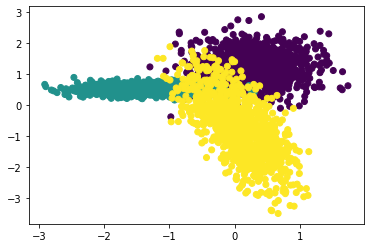

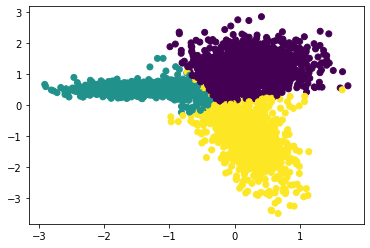

Acc: 0.9026666666666666


In [168]:
nn = NeuralNetwork(2, 3, activation_function="relu", loss_function='crossentropy', seed=123, verbose=True)

# Multiple layers
nn.add_layer(10)
nn.add_layer(10)

nn.create_output_layer("softmax")
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=10, lr=.001, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(y_test, axis=1).flatten())
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(pred, axis=1).flatten())
plt.show()

print("Acc: " + str(np.mean((np.argmax(y_test, axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

loss on batch = 18.62796029194575
loss on batch = 18.192521506751774
loss on batch = 16.303335408940082
loss on batch = 15.303562654408402
loss on batch = 13.975777705278405
loss on batch = 13.275091615309872
loss on batch = 12.161488885784786
loss on batch = 11.925465086609151
loss on batch = 15.371984105123225
loss on batch = 13.682432537365342
loss on batch = 14.098608164204558
loss on batch = 12.51322163873663
loss on batch = 11.6678412355166
loss on batch = 11.515428930745065
loss on batch = 10.926937380596407
loss on batch = 11.933224527055321
loss on batch = 10.927944242326092
loss on batch = 10.744513535351372
loss on batch = 11.117989723871933
loss on batch = 10.755585413757961
loss on batch = 10.811281364546943
loss on batch = 11.125604716234896
loss on batch = 11.061240312094343
loss on batch = 10.830504940260013
loss on batch = 10.705469906033716
loss on batch = 10.57632502275594
loss on batch = 10.882060029859918
loss on batch = 11.298113938946123
loss on batch = 10.719964

loss on batch = 7.924273013542455
loss on batch = 7.934827875432082
loss on batch = 9.932502987795955
loss on batch = 8.23362402879235
loss on batch = 7.425000143105635
loss on batch = 8.216761942116424
loss on batch = 9.377034246225293
loss on batch = 6.828949612161599
loss on batch = 8.617427265672305
loss on batch = 6.894620367527768
loss on batch = 7.959400286988329
loss on batch = 9.451707560145787
loss on batch = 9.42209655655969
loss on batch = 8.300647946562387
loss on batch = 9.064891213126108
loss on batch = 8.132982924061428
loss on batch = 9.165267677293594
loss on batch = 7.5847099460977
loss on batch = 7.428019876478163
loss on batch = 8.205383782563061
loss on batch = 8.206286149349381
loss on batch = 8.432346151002903
loss on batch = 8.415418128174775
loss on batch = 9.13183127747339
loss on batch = 8.11474884511932
loss on batch = 8.485930661029716
loss on batch = 8.254499355099842
loss on batch = 9.658505342127233
loss on batch = 8.566819104867983
loss on batch = 8.08

loss on batch = 6.31791436073362
loss on batch = 6.422240069689845
loss on batch = 7.998416572228761
loss on batch = 7.427123947977443
loss on batch = 7.02779116583986
loss on batch = 8.108438686249217
loss on batch = 7.551921996538742
loss on batch = 7.0928329095021265
loss on batch = 6.8813373082760645
loss on batch = 8.06461468658581
loss on batch = 7.946533700742316
loss on batch = 6.712716228515478
loss on batch = 7.3392037746756555
loss on batch = 6.288275942402241
loss on batch = 7.308898862510546
loss on batch = 6.902133294398327
loss on batch = 7.11601732130963
loss on batch = 7.784459128935676
loss on batch = 7.271386266928216
loss on batch = 6.9886962006461335
loss on batch = 7.470530214268807
loss on batch = 7.385640638091317
loss on batch = 8.090033959219303
loss on batch = 6.7342313952041755
loss on batch = 6.501118535729849
loss on batch = 7.204183427612082
loss on batch = 6.439060971085495
loss on batch = 7.312683299047989
loss on batch = 7.866546825610979
loss on batch

loss on batch = 6.755425953651264
loss on batch = 5.825729123938607
loss on batch = 5.99919446739333
loss on batch = 5.780834515058476
loss on batch = 7.113919124294306
loss on batch = 6.242026474356563
loss on batch = 7.801323335621947
loss on batch = 6.732473362126681
loss on batch = 6.589828460876921
loss on batch = 6.265107812419066
loss on batch = 6.156371727763439
loss on batch = 6.103852278435179
loss on batch = 7.685678458143409
loss on batch = 6.202804031203124
loss on batch = 6.9573661725769975
loss on batch = 5.96449230395419
loss on batch = 5.857247960698014
loss on batch = 7.117808825654215
loss on batch = 6.101651032627955
loss on batch = 7.857319849626127
loss on batch = 6.530835172896088
loss on batch = 7.733285406419742
loss on batch = 6.873097919018902
loss on batch = 8.625350644875672
loss on batch = 5.830312916457066
loss on batch = 6.0063178519045
loss on batch = 7.168310572521878
loss on batch = 6.575440547064522
loss on batch = 6.017963255492068
loss on batch = 6

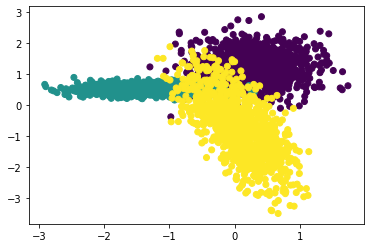

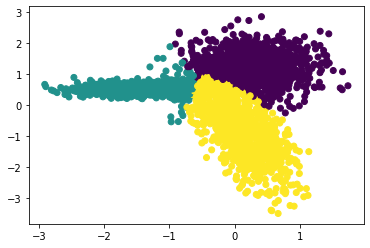

Acc: 0.9206666666666666


In [167]:
nn = NeuralNetwork(2, 3, activation_function="tanh", loss_function='crossentropy', seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer("softmax")
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(y_test, axis=1).flatten())
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(pred, axis=1).flatten())
plt.show()

print("Acc: " + str(np.mean((np.argmax(y_test, axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

## Testing different architectures

In [170]:
data = pd.read_csv("projekt1/regression/data.cube.test.10000.csv")
X_train = np.array(data.iloc[:,:1])
y_train = np.array(data.iloc[:,1:])
data = pd.read_csv("projekt1/regression/data.cube.test.10000.csv")
X_test = np.array(data.iloc[:,:1])
y_test = np.array(data.iloc[:,1:])
X_test = (X_test - np.mean(X_train)) / np.std(X_train)
y_test = (y_test - np.mean(y_train)) / np.std(y_train)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
y_train = (y_train - np.mean(y_train)) / np.std(y_train)
print(X_train)
print(y_train)

[[-1.73060923]
 [-1.72772488]
 [-1.72484054]
 ...
 [ 1.72484054]
 [ 1.72772488]
 [ 1.73060923]]
[[-3.23997454]
 [-3.22379534]
 [-3.20766376]
 ...
 [ 1.70719167]
 [ 1.71575781]
 [ 1.72435893]]


loss on batch = 4.664503154970145
loss on batch = 3.5923082851098287
loss on batch = 4.208063239685218
loss on batch = 3.156181025411837
loss on batch = 2.646321647122524
loss on batch = 3.917330465832471
loss on batch = 5.443666770373763
loss on batch = 3.738395409706153
loss on batch = 5.809527882331383
loss on batch = 5.624975521834467
loss on batch = 3.1180516775611973
loss on batch = 4.3449563396525805
loss on batch = 5.754327616713397
loss on batch = 3.757912764583272
loss on batch = 4.6152709191863766
loss on batch = 3.3080900341386976
loss on batch = 4.464002930931324
loss on batch = 3.1532959114514036
loss on batch = 1.9941816808441035
loss on batch = 3.1883123052586897
loss on batch = 2.6672473851129257
loss on batch = 3.7094887350655537
loss on batch = 3.095676797155446
loss on batch = 5.245194372384213
loss on batch = 5.113642280689877
loss on batch = 3.5747913103507862
loss on batch = 1.9919311887419542
loss on batch = 5.033127075204704
loss on batch = 6.59962580440745
los

loss on batch = 1.982197151546363
loss on batch = 4.466884857707217
loss on batch = 3.32861655829991
loss on batch = 3.8726243356873034
loss on batch = 1.8989024061066788
loss on batch = 4.989447755413694
loss on batch = 3.412777562331023
loss on batch = 2.4492131116471807
loss on batch = 1.854060391785317
loss on batch = 1.7431651505991201
loss on batch = 3.431127362914555
loss on batch = 2.2929088555929855
loss on batch = 2.1145915019597568
loss on batch = 3.8533471025358295
loss on batch = 1.590649961618178
loss on batch = 3.9395042901135366
loss on batch = 5.2564123697022005
loss on batch = 2.792476887040698
loss on batch = 2.924778026366124
loss on batch = 2.4198058462577543
loss on batch = 3.5008998379511427
loss on batch = 3.435304681708676
loss on batch = 3.55684364772918
loss on batch = 3.7218835720571994
loss on batch = 2.306762093696064
loss on batch = 1.500179787934434
loss on batch = 2.271551584290596
loss on batch = 2.1520671137596095
loss on batch = 4.038417983816844
los

loss on batch = 3.9847554760510264
loss on batch = 3.5823646036626604
loss on batch = 2.716291190739377
loss on batch = 1.8151796403564033
loss on batch = 2.447828911482108
loss on batch = 3.289096475439384
loss on batch = 4.418511208204067
loss on batch = 1.9568251311382445
loss on batch = 3.4532764932922184
loss on batch = 2.4404380517345485
loss on batch = 3.927313790352582
loss on batch = 4.634626725780412
loss on batch = 4.228735909315454
loss on batch = 1.8559782800933737
loss on batch = 4.324302710348014
loss on batch = 3.2964217776518
loss on batch = 2.321850501304375
loss on batch = 4.301388224871238
loss on batch = 4.569009755495325
loss on batch = 3.4819246966360384
loss on batch = 2.5746404472980617
loss on batch = 2.993131992070688
loss on batch = 2.2795101548357555
loss on batch = 3.6382296935218843
loss on batch = 2.042928232220151
loss on batch = 4.150609079672165
loss on batch = 4.997135183893519
loss on batch = 3.351175067211124
loss on batch = 4.054438006489101
loss 

loss on batch = 2.2555048768842885
loss on batch = 3.327086237823215
loss on batch = 2.469405571308427
loss on batch = 4.247056981535142
loss on batch = 3.2589453867934353
loss on batch = 1.8576989965253703
loss on batch = 2.349303168045056
loss on batch = 1.901494893615643
loss on batch = 1.7439791676576926
loss on batch = 3.6238978492475935
loss on batch = 2.1715052323334314
loss on batch = 1.8931954116000058
loss on batch = 2.154976822416187
loss on batch = 3.8269531430467203
loss on batch = 2.436646399270679
loss on batch = 4.171264618983487
loss on batch = 4.086831043658848
loss on batch = 3.105307873547859
loss on batch = 3.179726318567547
loss on batch = 2.0852009408492194
loss on batch = 3.8970246677732394
loss on batch = 3.472627601750808
loss on batch = 3.407522843272801
loss on batch = 3.951580852153281
loss on batch = 3.833937658547264
loss on batch = 0.3367719661324142
loss on batch = 1.653957544738243
loss on batch = 2.197996528864749
loss on batch = 3.482413598792172
los

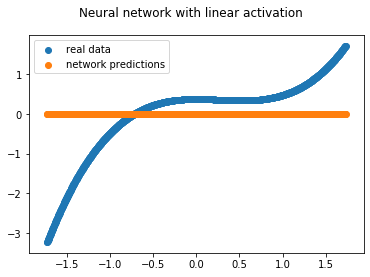

MSE: 1.0000053872883345


In [196]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123, verbose=True)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.01, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 16.381951651556122
loss on batch = 14.614453144183027
loss on batch = 9.48493833740449
loss on batch = 12.635383187788289
loss on batch = 14.772349863720104
loss on batch = 14.60686375196911
loss on batch = 9.712786179896854
loss on batch = 9.339042108711999
loss on batch = 14.057317012474666
loss on batch = 12.74005844327921
loss on batch = 9.392432239249096
loss on batch = 9.823959550101659
loss on batch = 7.7709413173421416
loss on batch = 9.318500617168658
loss on batch = 10.076805620892568
loss on batch = 9.844971640538448
loss on batch = 6.297739094753323
loss on batch = 7.505919150387893
loss on batch = 10.188872055421319
loss on batch = 8.775656331806687
loss on batch = 7.047781023769059
loss on batch = 7.737223084178816
loss on batch = 8.028022695128598
loss on batch = 7.3110950456030315
loss on batch = 7.91751374412924
loss on batch = 8.426633681125134
loss on batch = 3.766602293257584
loss on batch = 7.5484830779447
loss on batch = 5.563734678786162
loss on b

loss on batch = 0.6453112659885758
loss on batch = 0.9243373769272633
loss on batch = 0.3339846482184908
loss on batch = 1.1187868403517318
loss on batch = 0.8808453213219783
loss on batch = 0.6617326266490164
loss on batch = 0.6674797152102104
loss on batch = 0.3301895874262659
loss on batch = 0.8297486528280726
loss on batch = 0.5865093999680123
loss on batch = 0.4529753776170938
loss on batch = 0.7771859171095903
loss on batch = 0.4572448131637498
loss on batch = 0.8756627745806775
loss on batch = 1.1387269907588597
loss on batch = 0.6307569365789143
loss on batch = 0.8298428293417187
loss on batch = 0.5302239593337081
loss on batch = 0.398271391168293
loss on batch = 0.9033804916841354
loss on batch = 0.9746339991818007
loss on batch = 0.7961129261453692
loss on batch = 0.7243951366274631
loss on batch = 0.34867532865056494
loss on batch = 0.8007968146349117
loss on batch = 0.4282121600066858
loss on batch = 0.8322551974188818
loss on batch = 0.9122030305988885
loss on batch = 0.68

loss on batch = 0.4095668921761278
loss on batch = 0.461101255137807
loss on batch = 0.47460522492570417
loss on batch = 0.657091251529189
loss on batch = 0.44460151740515685
loss on batch = 0.5742721098636865
loss on batch = 0.37296126434987464
loss on batch = 0.7099004747584554
loss on batch = 0.27376055285343437
loss on batch = 0.8243460781675647
loss on batch = 0.5469236706803247
loss on batch = 0.5847031803274065
loss on batch = 0.600539747716407
loss on batch = 0.8300329161064331
loss on batch = 0.7593732157243375
loss on batch = 0.5098021269177321
loss on batch = 0.5561942776800536
loss on batch = 0.6013626384656144
loss on batch = 0.4879713787607402
loss on batch = 0.24162750909481112
loss on batch = 0.750446606447264
loss on batch = 0.6526392444017642
loss on batch = 0.6569043969769351
loss on batch = 0.39654292310183353
loss on batch = 0.6253939139344495
loss on batch = 0.7232607484379376
loss on batch = 0.6833924101941682
loss on batch = 0.7776573642948821
loss on batch = 0.

loss on batch = 0.7980526411977908
loss on batch = 0.47930685820246766
loss on batch = 0.4379742425813049
loss on batch = 0.5004350810967795
loss on batch = 0.5113243156531506
loss on batch = 0.8723797664727397
loss on batch = 0.7695205059371754
loss on batch = 0.4960941210348204
loss on batch = 0.44069621297064404
loss on batch = 0.5746193428363148
loss on batch = 0.445756525186813
loss on batch = 0.6624910241781634
loss on batch = 0.5494420119395319
loss on batch = 0.5212829969921757
loss on batch = 0.7693206239360371
loss on batch = 0.5445942267224742
loss on batch = 0.7009399808944442
loss on batch = 0.4634310528764301
loss on batch = 0.5915096467530796
loss on batch = 0.5997790080529959
loss on batch = 0.5857519481348511
loss on batch = 0.6362538689126606
loss on batch = 0.5826394127961131
loss on batch = 0.7177082123967334
loss on batch = 0.4208483505013722
loss on batch = 0.512361093244992
loss on batch = 0.46915777599756187
loss on batch = 0.6059372394406799
loss on batch = 0.4

loss on batch = 0.7169468821820117
loss on batch = 0.5980891039672284
loss on batch = 0.35036863081789243
loss on batch = 0.6551703037216007
loss on batch = 0.5433875952376522
loss on batch = 0.39535381095447286
loss on batch = 0.4108595280562686
loss on batch = 0.7050769938246801
loss on batch = 0.2665250273841674
loss on batch = 0.07340351750287687


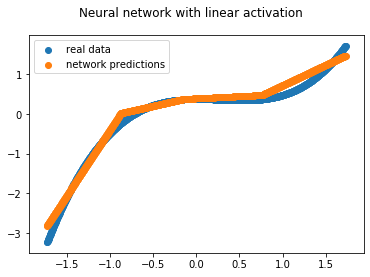

MSE: 0.019761190246907145


In [197]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.01, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 4.274146755157355
loss on batch = 4.258788612357749
loss on batch = 2.9671202875961433
loss on batch = 3.5551257657615403
loss on batch = 3.8413298561977975
loss on batch = 4.787357537793291
loss on batch = 4.250655073964902
loss on batch = 3.719454555058234
loss on batch = 5.069738245308596
loss on batch = 4.501642687992123
loss on batch = 3.0520809047106345
loss on batch = 3.4367902205642964
loss on batch = 3.9030687102001704
loss on batch = 3.2941127176451594
loss on batch = 3.935758055621136
loss on batch = 3.662933248941092
loss on batch = 3.035712377117473
loss on batch = 3.080698123172994
loss on batch = 4.115893723526793
loss on batch = 3.920295521610846
loss on batch = 3.486539652500739
loss on batch = 3.5104036889344563
loss on batch = 3.77634580915591
loss on batch = 4.280845833287368
loss on batch = 4.182153255321431
loss on batch = 4.013852091900111
loss on batch = 2.972280964032484
loss on batch = 4.59071693021916
loss on batch = 4.14944667396086
loss on b

loss on batch = 1.6540016103982524
loss on batch = 2.4989135559035787
loss on batch = 1.6562192539274607
loss on batch = 1.1538503106843003
loss on batch = 2.989078038902673
loss on batch = 1.4426157634485275
loss on batch = 3.059982682842237
loss on batch = 4.013949312042207
loss on batch = 1.653139637221402
loss on batch = 2.0944836869173935
loss on batch = 1.9538065524990809
loss on batch = 2.731585452342039
loss on batch = 2.559956585440811
loss on batch = 2.6492787265975886
loss on batch = 2.715392765924089
loss on batch = 1.6027954538423461
loss on batch = 1.2918753736156474
loss on batch = 1.3812003256921528
loss on batch = 1.9726576675136964
loss on batch = 3.155824372965243
loss on batch = 2.1378080825945527
loss on batch = 3.1297467063360283
loss on batch = 3.026826493359014
loss on batch = 2.2954581008257504
loss on batch = 2.4124380278027493
loss on batch = 2.1676631304623024
loss on batch = 0.9913962203930643
loss on batch = 2.6227641006390576
loss on batch = 1.47270866333

loss on batch = 1.3103563941285379
loss on batch = 2.721422178431151
loss on batch = 3.0213996628020157
loss on batch = 2.131469882585584
loss on batch = 1.435984014840766
loss on batch = 1.7162441484172075
loss on batch = 1.22666758619213
loss on batch = 1.6522202374450328
loss on batch = 0.8512666320697038
loss on batch = 2.593679872580736
loss on batch = 3.009602915490952
loss on batch = 1.804706392935613
loss on batch = 2.4637469376468077
loss on batch = 2.1809289177682034
loss on batch = 1.8538157637448192
loss on batch = 0.8276545575197698
loss on batch = 2.1496650361582463
loss on batch = 1.1786162335477772
loss on batch = 1.9267584151476282
loss on batch = 1.7564335063109802
loss on batch = 1.422812689095575
loss on batch = 1.0608206213246403
loss on batch = 0.7741113493909353
loss on batch = 1.6404430304504403
loss on batch = 2.049050463337318
loss on batch = 0.8560439875381629
loss on batch = 0.9677663257133792
loss on batch = 1.216266233790945
loss on batch = 1.9372650297081

loss on batch = 1.2338578561493896
loss on batch = 1.1046957588250446
loss on batch = 1.2745686806375718
loss on batch = 2.171394643253847
loss on batch = 0.9481752008662289
loss on batch = 2.111544535885124
loss on batch = 1.5434678910094513
loss on batch = 1.8285711768289452
loss on batch = 1.8367454436029815
loss on batch = 1.0513325020822275
loss on batch = 1.429885445842373
loss on batch = 0.7508357204989333
loss on batch = 0.8994098495360331
loss on batch = 1.449211039575972
loss on batch = 1.4569875960079572
loss on batch = 1.4487337996132195
loss on batch = 1.2473677828519554
loss on batch = 1.2306956139665028
loss on batch = 1.3472521454163848
loss on batch = 2.6901683004255537
loss on batch = 1.4186258928768911
loss on batch = 1.3533052250048614
loss on batch = 1.9803118705288212
loss on batch = 2.324955115810522
loss on batch = 0.9561410507815897
loss on batch = 2.457594946534417
loss on batch = 1.8378300869488542
loss on batch = 1.0401856006538885
loss on batch = 1.38975223

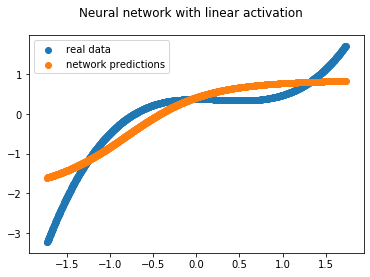

MSE: 0.18481239226600585


In [206]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=True)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 8.091859915818747
loss on batch = 8.73052875494804
loss on batch = 6.65633414408783
loss on batch = 8.122241563011496
loss on batch = 8.77412793531796
loss on batch = 9.203799032473961
loss on batch = 6.746523444866784
loss on batch = 7.353371834580851
loss on batch = 8.280297266019307
loss on batch = 7.656245624103256
loss on batch = 7.449938051034917
loss on batch = 7.027684183935134
loss on batch = 5.732039752184653
loss on batch = 7.136335325558079
loss on batch = 7.598943476115468
loss on batch = 8.000243103216762
loss on batch = 5.909751216850089
loss on batch = 6.953984708066537
loss on batch = 9.241991848731377
loss on batch = 8.250807441792796
loss on batch = 7.737488063866962
loss on batch = 7.557824304704264
loss on batch = 8.218377626349099
loss on batch = 6.727770966344783
loss on batch = 7.086765319794338
loss on batch = 8.414456921173826
loss on batch = 6.946645369409376
loss on batch = 7.76186898854604
loss on batch = 4.413096217542517
loss on batch = 7.

loss on batch = 2.4495202729969177
loss on batch = 1.433492674669472
loss on batch = 1.8386948067220472
loss on batch = 1.7486581345038856
loss on batch = 3.283398189617498
loss on batch = 3.4760018763942937
loss on batch = 1.940486672382665
loss on batch = 2.4430210804468695
loss on batch = 2.0204457094484742
loss on batch = 3.074558852052487
loss on batch = 1.659737860221233
loss on batch = 2.122986697291533
loss on batch = 2.8413789921904042
loss on batch = 2.529700394406067
loss on batch = 1.8699904035761719
loss on batch = 0.7405936067046569
loss on batch = 1.5197103286404976
loss on batch = 2.577571540022683
loss on batch = 3.1353187401819107
loss on batch = 1.1609225783174337
loss on batch = 2.542527567685949
loss on batch = 1.2703276267453365
loss on batch = 2.909588217103292
loss on batch = 3.588558799594452
loss on batch = 2.8810466156821355
loss on batch = 0.7395604320296432
loss on batch = 2.9980818522845216
loss on batch = 2.134076502950455
loss on batch = 1.39839861969031

loss on batch = 0.8470159548567755
loss on batch = 1.8588622664759944
loss on batch = 1.468054393183859
loss on batch = 1.0790787885211426
loss on batch = 0.8556234197757284
loss on batch = 0.851762866859496
loss on batch = 0.7062203656164887
loss on batch = 1.197243912271975
loss on batch = 0.7506917393105508
loss on batch = 0.6821653824638801
loss on batch = 0.8506858642185585
loss on batch = 1.1817876697145686
loss on batch = 0.8903175960665962
loss on batch = 1.8065083823165
loss on batch = 1.6795909269223182
loss on batch = 1.4230807302367838
loss on batch = 0.9933896433049813
loss on batch = 1.0757286483245465
loss on batch = 1.6612262298812015
loss on batch = 1.5056142077945405
loss on batch = 1.450096211218036
loss on batch = 1.5065900768329652
loss on batch = 1.7539406236683979
loss on batch = 0.14020873555521685
loss on batch = 0.5799553716373315
loss on batch = 0.9854121772447653
loss on batch = 1.7094078233989292
loss on batch = 1.0240611432944569
loss on batch = 1.39038420

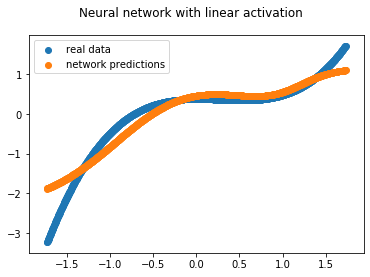

MSE: 0.09552441470722672


In [207]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 3.234678787991241
loss on batch = 2.9293140242536455
loss on batch = 2.209675748355781
loss on batch = 2.134580812693443
loss on batch = 2.0497544959999736
loss on batch = 3.480678574220821
loss on batch = 3.7528823648100813
loss on batch = 2.440866337035728
loss on batch = 4.530770178702595
loss on batch = 4.139407573952006
loss on batch = 1.8299704436168596
loss on batch = 2.796838630407716
loss on batch = 3.8168515249681434
loss on batch = 2.3597355986521693
loss on batch = 3.4199263932776414
loss on batch = 2.4991305861824507
loss on batch = 2.6818339353452605
loss on batch = 1.7863062957002493
loss on batch = 2.515009336698518
loss on batch = 2.7137891229591427
loss on batch = 2.0701123053458885
loss on batch = 2.863657593182746
loss on batch = 2.695354603209223
loss on batch = 3.9312538509214283
loss on batch = 3.875656655370563
loss on batch = 3.1481756985648537
loss on batch = 1.1157545207461348
loss on batch = 4.220086412631531
loss on batch = 4.693621667793738

loss on batch = 2.6897984197542377
loss on batch = 1.977701838377364
loss on batch = 2.0034851839950565
loss on batch = 4.431878286068782
loss on batch = 3.358184961910188
loss on batch = 3.8496287242219807
loss on batch = 1.9002044111089635
loss on batch = 4.971715465062888
loss on batch = 3.432916793254203
loss on batch = 2.4490206387916422
loss on batch = 1.9383755677983572
loss on batch = 1.767464944592992
loss on batch = 3.420763125942785
loss on batch = 2.3219378893518807
loss on batch = 2.096614761293978
loss on batch = 3.820900769222015
loss on batch = 1.6258992073410787
loss on batch = 3.9187912446683493
loss on batch = 5.235978702141146
loss on batch = 2.791908341080096
loss on batch = 2.9339033732951614
loss on batch = 2.409479299420463
loss on batch = 3.4963690082099603
loss on batch = 3.4355948225776825
loss on batch = 3.5568907488156136
loss on batch = 3.7310273775517455
loss on batch = 2.3049216765400202
loss on batch = 1.5083011921918545
loss on batch = 2.28396394467494

loss on batch = 2.7784114277071943
loss on batch = 3.9206021204179398
loss on batch = 4.188928353846197
loss on batch = 3.1284017995751383
loss on batch = 3.2528661052467043
loss on batch = 1.4514003552145731
loss on batch = 2.9684033867734967
loss on batch = 4.5215654942936885
loss on batch = 1.7892435619936682
loss on batch = 4.604618115202225
loss on batch = 3.701975890284492
loss on batch = 2.4779293421966266
loss on batch = 3.064575125695319
loss on batch = 3.9400169514214736
loss on batch = 1.586242331691241
loss on batch = 3.4489235045343376
loss on batch = 2.7564532144545466
loss on batch = 3.1658819644146092
loss on batch = 3.904349849055427
loss on batch = 2.1150056363321803
loss on batch = 1.8364574745693478
loss on batch = 3.3619703366741227
loss on batch = 3.562987201915317
loss on batch = 2.6520831253208335
loss on batch = 3.143481810782953
loss on batch = 3.9020335897417273
loss on batch = 2.081463111471204
loss on batch = 2.1054581518877558
loss on batch = 2.78114337331

loss on batch = 4.932665530344332
loss on batch = 3.159627968977579
loss on batch = 2.9372188449759533
loss on batch = 4.038037731736715
loss on batch = 4.244660970973182
loss on batch = 2.2679615676387406
loss on batch = 4.5683384022013325
loss on batch = 3.363095267504373
loss on batch = 2.6735860896796533
loss on batch = 2.7669936705410834
loss on batch = 1.9159938793675322
loss on batch = 3.886332349259427
loss on batch = 1.3860876517463807
loss on batch = 1.1700171367282008
loss on batch = 1.4504531301057042
loss on batch = 3.2695104685038516
loss on batch = 2.52136968012212
loss on batch = 1.6188168377194285
loss on batch = 1.8852792115075496
loss on batch = 2.707122922747994
loss on batch = 2.776531600561661
loss on batch = 2.378696776099376
loss on batch = 2.4007911584598327
loss on batch = 2.3644225901156837
loss on batch = 5.965621140599425
loss on batch = 3.805989077419486
loss on batch = 3.3349828364156915
loss on batch = 4.493702134898138
loss on batch = 2.610401351061531


loss on batch = 4.503220889771932
loss on batch = 3.763155834652926
loss on batch = 3.154163242586181
loss on batch = 3.0151416551248515
loss on batch = 3.1360053361385
loss on batch = 0.7012317705477478
loss on batch = 1.8302251751226137
loss on batch = 3.016437331914867
loss on batch = 3.7034306832501724
loss on batch = 2.2628494435034523
loss on batch = 4.704217804259
loss on batch = 4.8957087018455505
loss on batch = 4.520778020306958
loss on batch = 1.9610291954328163
loss on batch = 4.4810236705245075
loss on batch = 2.3184191802650003
loss on batch = 2.030304739033938
loss on batch = 1.8673035467729402
loss on batch = 2.3727332924006226
loss on batch = 3.303339497675365
loss on batch = 4.605881066296937
loss on batch = 4.4546809096732956
loss on batch = 2.608558613132579
loss on batch = 2.5640567787817585
loss on batch = 4.504598888273593
loss on batch = 3.62154811288279
loss on batch = 3.1013436697668144
loss on batch = 2.7617754620404287
loss on batch = 2.9882796911196614
loss

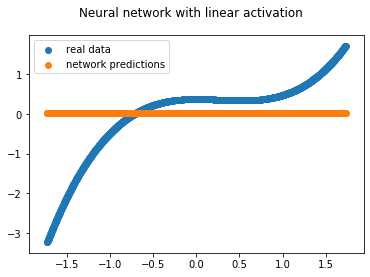

MSE: 1.0004317093969084


In [209]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123, verbose=True)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 6.250428720185198
loss on batch = 6.871678245730947
loss on batch = 5.396338170047126
loss on batch = 6.380911415034777
loss on batch = 6.671796510593272
loss on batch = 7.142172972222639
loss on batch = 5.594938256032661
loss on batch = 5.953691861996879
loss on batch = 6.368478232682154
loss on batch = 5.853006997033312
loss on batch = 5.833652413290858
loss on batch = 5.455336194450915
loss on batch = 4.783283384186982
loss on batch = 5.5500734765261095
loss on batch = 5.876864374126678
loss on batch = 6.104685515130587
loss on batch = 4.831823884412677
loss on batch = 5.430782658697608
loss on batch = 6.980848608841771
loss on batch = 6.323206859753295
loss on batch = 6.034930170727626
loss on batch = 5.8924450324464495
loss on batch = 6.285035863690418
loss on batch = 5.336431241001251
loss on batch = 5.411618065616905
loss on batch = 6.294299900767943
loss on batch = 5.550541965274411
loss on batch = 6.112443115337083
loss on batch = 3.655291116888414
loss on batc

loss on batch = 3.8853646139419453
loss on batch = 1.899758416992974
loss on batch = 4.990056508530307
loss on batch = 3.405779787652933
loss on batch = 2.4496950655738665
loss on batch = 1.8048107669362314
loss on batch = 1.7308811076601256
loss on batch = 3.4361236655048284
loss on batch = 2.276841371914579
loss on batch = 2.122527235687258
loss on batch = 3.8518020935805697
loss on batch = 1.5824831823441101
loss on batch = 3.9339892965903487
loss on batch = 5.230593519369871
loss on batch = 2.7917734317936747
loss on batch = 2.9285126191134876
loss on batch = 2.4027590641464984
loss on batch = 3.472677422312952
loss on batch = 3.437274590549796
loss on batch = 3.550338344564216
loss on batch = 3.6670936118038946
loss on batch = 2.351039723322051
loss on batch = 1.5421634437815301
loss on batch = 2.2854949885249183
loss on batch = 2.1503259465400113
loss on batch = 4.022228447641283
loss on batch = 2.8895802156495605
loss on batch = 4.136871986620151
loss on batch = 4.14863604360112

loss on batch = 4.469266637193654
loss on batch = 2.6510180919313093
loss on batch = 3.3976002802726475
loss on batch = 2.8782258328989725
loss on batch = 4.15494203959948
loss on batch = 2.529272124712303
loss on batch = 3.1466827746509964
loss on batch = 3.97739948998202
loss on batch = 3.570235902006052
loss on batch = 2.7090321605339818
loss on batch = 1.7725668362133744
loss on batch = 2.484277673098522
loss on batch = 3.2839527249510025
loss on batch = 4.356854152588788
loss on batch = 1.9412570212844942
loss on batch = 3.4458139803918106
loss on batch = 2.4380290307784196
loss on batch = 3.91396936681579
loss on batch = 4.585084644820195
loss on batch = 4.180536009533592
loss on batch = 2.0108857818276014
loss on batch = 4.2617575870664695
loss on batch = 3.3994361595390394
loss on batch = 2.357651016907958
loss on batch = 4.260994925523441
loss on batch = 4.49703504904533
loss on batch = 3.3960798051403343
loss on batch = 2.481147815283972
loss on batch = 3.027310322062038
loss

loss on batch = 2.684461103713489
loss on batch = 3.680855684490858
loss on batch = 5.799145101777387
loss on batch = 4.205976702618963
loss on batch = 3.068783190709524
loss on batch = 3.2501577437374354
loss on batch = 3.29636065160663
loss on batch = 4.372148546330509
loss on batch = 2.6172238789449045
loss on batch = 2.1962181118556887
loss on batch = 1.5893169695095897
loss on batch = 3.460259806321165
loss on batch = 2.203063195108007
loss on batch = 4.140186866833126
loss on batch = 1.0114595853726378
loss on batch = 3.1530991383916747
loss on batch = 2.0817112188776914
loss on batch = 2.8311838313552697
loss on batch = 3.476788987608262
loss on batch = 4.991935244935121
loss on batch = 1.8471401571218542
loss on batch = 3.040147460632403
loss on batch = 4.196758742438143
loss on batch = 3.1057791615568036
loss on batch = 2.262152569215893
loss on batch = 2.020822411823362
loss on batch = 3.4630127553372327
loss on batch = 3.983801618752002
loss on batch = 1.7767264395829812
los

loss on batch = 0.627877283730612
loss on batch = 2.625072707226022
loss on batch = 2.7130125676996486
loss on batch = 3.2828779463953772
loss on batch = 2.5417202413432203
loss on batch = 3.74181879200285
loss on batch = 1.5680979348692476
loss on batch = 2.6644356801030527
loss on batch = 2.7784721774913534
loss on batch = 1.8114623595089654
loss on batch = 2.3636412376670997
loss on batch = 2.0230312155593366
loss on batch = 1.7554775388057438
loss on batch = 2.4448136852686626
loss on batch = 3.8647767388315573
loss on batch = 2.0960384530156113
loss on batch = 0.7147918541050923
loss on batch = 2.2674328558860064
loss on batch = 1.965233773279031
loss on batch = 1.1541691629103323
loss on batch = 1.4243234325796121
loss on batch = 2.448587460098176
loss on batch = 2.3831232670147457
loss on batch = 2.734048162247696
loss on batch = 3.937835612850526
loss on batch = 0.9069571221048347
loss on batch = 1.4251563529344085
loss on batch = 3.3933406020217745
loss on batch = 1.0870472301

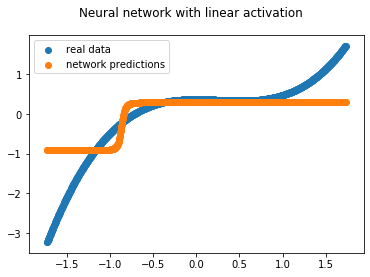

MSE: 0.38566628393385494


In [208]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=True)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 26.728067203200826
loss on batch = 29.080652018202045
loss on batch = 34.15021637300045
loss on batch = 28.980013502194616
loss on batch = 22.757581268552762
loss on batch = 23.14255489555339
loss on batch = 30.693464059273143
loss on batch = 27.23918199225578
loss on batch = 24.909068011380825
loss on batch = 28.98424834152941
loss on batch = 27.661723165775083
loss on batch = 28.230674241373812
loss on batch = 31.681499199221452
loss on batch = 25.87455134511219
loss on batch = 28.035927069525037
loss on batch = 22.873791752750684
loss on batch = 29.732384911820613
loss on batch = 23.13728535790808
loss on batch = 17.09020334077989
loss on batch = 20.407249914320474
loss on batch = 22.298157955623985
loss on batch = 26.246217070305537
loss on batch = 21.5312615329454
loss on batch = 23.811144064122434
loss on batch = 23.079696570068766
loss on batch = 18.944102087844442
loss on batch = 20.553177688955596
loss on batch = 23.547036555942668
loss on batch = 28.0173227109

loss on batch = 0.9590389043906914
loss on batch = 0.5762069462501023
loss on batch = 1.1943851923516897
loss on batch = 1.393494191391317
loss on batch = 1.2546665309661773
loss on batch = 1.0928396807649938
loss on batch = 0.8373702132992308
loss on batch = 1.2928197161103916
loss on batch = 1.3191067672831671
loss on batch = 1.2449144091672393
loss on batch = 0.7674950295353965
loss on batch = 0.8241580005917702
loss on batch = 0.5521272233289266
loss on batch = 1.295728853726122
loss on batch = 0.7924030383174725
loss on batch = 1.0986266729308276
loss on batch = 1.1698066324583005
loss on batch = 1.2189712287576986
loss on batch = 1.0572666425994333
loss on batch = 1.3930303544192255
loss on batch = 0.607974135932785
loss on batch = 1.0704913360606085
loss on batch = 0.21427077308768416
loss on batch = 0.7564727866014983
loss on batch = 0.7101045972908887
loss on batch = 1.0719817688211621
loss on batch = 1.0777728166987475
loss on batch = 0.7589155355458341
loss on batch = 1.2294

loss on batch = 0.32632782205228605
loss on batch = 0.896059008872146
loss on batch = 0.40550961661058965
loss on batch = 0.4819292605784324
loss on batch = 0.45069933893737457
loss on batch = 0.40911428969125496
loss on batch = 0.6704152002322242
loss on batch = 0.49075242387426493
loss on batch = 1.267223257329611
loss on batch = 0.5106858611340225
loss on batch = 1.040825000597292
loss on batch = 0.9922591079041686
loss on batch = 0.8758258868832716
loss on batch = 1.0088251980303726
loss on batch = 0.9750028413308539
loss on batch = 0.6346805543454527
loss on batch = 0.4452260550207652
loss on batch = 1.3349583861993413
loss on batch = 0.7151301138139848
loss on batch = 0.5811034420391327
loss on batch = 0.7815618128151764
loss on batch = 0.7965700409981121
loss on batch = 0.5585015867995438
loss on batch = 0.7429428491427023
loss on batch = 0.6899824281022413
loss on batch = 1.052070226456383
loss on batch = 1.276571591680036
loss on batch = 0.5878317696367814
loss on batch = 0.40

loss on batch = 0.7356969154152184
loss on batch = 1.0295471760950492
loss on batch = 0.6449650887277271
loss on batch = 0.6673194135554108
loss on batch = 0.7165330658495116
loss on batch = 0.7173853367371024
loss on batch = 0.3762564476415462
loss on batch = 0.504059271787004
loss on batch = 0.5384186906747304
loss on batch = 0.7167153067085081
loss on batch = 0.3519773099499449
loss on batch = 0.8002803022039198
loss on batch = 0.6021063811386937
loss on batch = 0.3917711202159217
loss on batch = 0.45198778782578153
loss on batch = 0.3760408087080294
loss on batch = 0.541675710375664
loss on batch = 0.4204285809742058
loss on batch = 0.771656647074413
loss on batch = 0.6594320920467432
loss on batch = 1.010169686615629
loss on batch = 0.8404533827241537
loss on batch = 0.5845234933020648
loss on batch = 0.8788861226324692
loss on batch = 1.3873368288111667
loss on batch = 0.8677887539992108
loss on batch = 0.7156601189026082
loss on batch = 0.5928702064827754
loss on batch = 0.75722

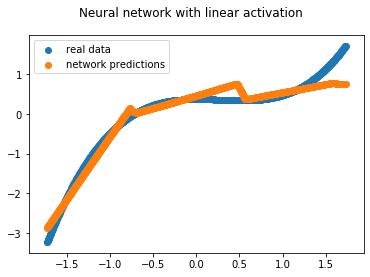

MSE: 0.05409879222572243


In [217]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 6.465058541805402
loss on batch = 5.9955656504350685
loss on batch = 5.680698289760335
loss on batch = 5.770372003859903
loss on batch = 6.277315104680599
loss on batch = 5.962349063123997
loss on batch = 5.849675468914222
loss on batch = 6.168778599283147
loss on batch = 5.4067385585245225
loss on batch = 4.464101115536623
loss on batch = 5.330886665902592
loss on batch = 4.892471834568207
loss on batch = 4.861047832604088
loss on batch = 5.156365948391583
loss on batch = 4.148569572506464
loss on batch = 4.7697001011682705
loss on batch = 4.695648054023174
loss on batch = 5.2517336249690105
loss on batch = 4.757768171874463
loss on batch = 4.844257027869116
loss on batch = 4.6629349395775606
loss on batch = 3.787935973972724
loss on batch = 4.070647735348896
loss on batch = 4.692184611438857
loss on batch = 3.943007159462317
loss on batch = 3.564934857435898
loss on batch = 5.162754401485611
loss on batch = 4.131739268988932
loss on batch = 3.46714792715572
loss on ba

loss on batch = 1.0494198946838325
loss on batch = 2.5812397548504613
loss on batch = 2.2479690945275084
loss on batch = 2.399265430905286
loss on batch = 1.1575597741830648
loss on batch = 2.6896855411194784
loss on batch = 1.2731674803294781
loss on batch = 2.0123285330718748
loss on batch = 1.385412937251311
loss on batch = 1.824946747393486
loss on batch = 2.792319118648528
loss on batch = 1.458968578717604
loss on batch = 2.7591656071136725
loss on batch = 3.055042609001194
loss on batch = 2.0125984550458034
loss on batch = 1.583896361262592
loss on batch = 0.029264653084818404
loss on batch = 2.5047357435305977
loss on batch = 1.6183284488715002
loss on batch = 2.718996530433993
loss on batch = 2.702106012591962
loss on batch = 2.1855536249433314
loss on batch = 2.1150215536327814
loss on batch = 1.4127177475070802
loss on batch = 3.47753576847921
loss on batch = 3.082471618673766
loss on batch = 2.525341096345155
loss on batch = 1.208249120009593
loss on batch = 1.23328732789716

loss on batch = 0.6515071830326663
loss on batch = 1.0894160890915459
loss on batch = 1.2032059432177045
loss on batch = 0.4702183604754959
loss on batch = 0.34669965307686734
loss on batch = 0.7461358729556865
loss on batch = 0.5772213637527187
loss on batch = 0.3405739708897538
loss on batch = 1.7543400006247347
loss on batch = 0.773523928787363
loss on batch = 0.6416234851784038
loss on batch = 0.48109480616662154
loss on batch = 1.1389642610427724
loss on batch = 0.36032981584924184
loss on batch = 0.5281750749017786
loss on batch = 0.39558253515385017
loss on batch = 0.9247005885179539
loss on batch = 0.7831092740069269
loss on batch = 1.0931961631963643
loss on batch = 0.9876406496602178
loss on batch = 0.958301318401571
loss on batch = 0.4553433046968478
loss on batch = 0.6936655403439459
loss on batch = 0.47932621282431576
loss on batch = 0.41395198710900777
loss on batch = 0.8019510407223965
loss on batch = 1.1592545175151912
loss on batch = 0.46624013045621454
loss on batch =

loss on batch = 0.2187075665792284
loss on batch = 0.32556658717662756
loss on batch = 0.3776208933360831
loss on batch = 0.5431453235358144
loss on batch = 0.34798930989902466
loss on batch = 0.38706010073238867
loss on batch = 0.3732831044584065
loss on batch = 0.43358669061684124
loss on batch = 0.5339195067636309
loss on batch = 0.2559621212561999
loss on batch = 0.600436044114301
loss on batch = 0.3959301558519586
loss on batch = 0.31350572179780956
loss on batch = 0.4456862529795266
loss on batch = 0.2773042201311866
loss on batch = 0.3927539956025823
loss on batch = 0.39463405074697644
loss on batch = 0.6028855151702145
loss on batch = 0.1920986719656267
loss on batch = 0.25059214712061867
loss on batch = 0.2768692320199244
loss on batch = 0.21491029307537263
loss on batch = 0.33828456452122907
loss on batch = 0.4513006950727913
loss on batch = 0.5374941861656963
loss on batch = 0.36048473408279763
loss on batch = 0.5573963713420933
loss on batch = 0.8780671501297813
loss on bat

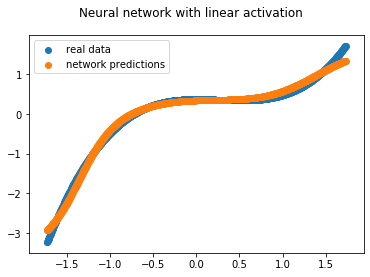

MSE: 0.008108423323469503


In [218]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 33.5068550648757
loss on batch = 31.42623379118551
loss on batch = 31.397477248193166
loss on batch = 31.165796679281033
loss on batch = 31.575198817015313
loss on batch = 30.983776234838004
loss on batch = 30.625542887375513
loss on batch = 29.077939870314047
loss on batch = 32.22600142018938
loss on batch = 31.56943339236168
loss on batch = 29.174289633306444
loss on batch = 29.830319764709458
loss on batch = 29.344798886615923
loss on batch = 29.083679756982576
loss on batch = 28.958950647641355
loss on batch = 28.31579339733859
loss on batch = 27.326032919122422
loss on batch = 27.768843030633654
loss on batch = 26.886213144633114
loss on batch = 26.505973853573426
loss on batch = 25.604316686506206
loss on batch = 25.379474792502556
loss on batch = 25.465027784132687
loss on batch = 26.278560305476255
loss on batch = 26.16498871120551
loss on batch = 24.368702848644165
loss on batch = 23.598484099326036
loss on batch = 23.891104794858382
loss on batch = 26.22860283

loss on batch = 0.6004387850019574
loss on batch = 0.3617974489286567
loss on batch = 0.5243417825711919
loss on batch = 0.4192476144236525
loss on batch = 0.4299298102459593
loss on batch = 0.4308906747123281
loss on batch = 0.46235482427535557
loss on batch = 0.47525893451322604
loss on batch = 0.5983691086236448
loss on batch = 0.45239048504206286
loss on batch = 0.2816942266221826
loss on batch = 0.2863621060795848
loss on batch = 0.30245431962823244
loss on batch = 0.48944011628948014
loss on batch = 0.5083936242572843
loss on batch = 0.44516543663694
loss on batch = 0.5227903007580463
loss on batch = 0.41449804231833787
loss on batch = 0.30340689975510804
loss on batch = 0.2941796716858191
loss on batch = 0.44216286547811434
loss on batch = 0.36754459563360004
loss on batch = 0.5359725198312414
loss on batch = 0.41076590088107146
loss on batch = 0.40875670219168164
loss on batch = 0.3208035811484244
loss on batch = 0.43577694649593823
loss on batch = 0.4583869115812523
loss on ba

loss on batch = 0.20570249977483085
loss on batch = 0.14235344710738618
loss on batch = 0.13556583295446278
loss on batch = 0.2331251344117508
loss on batch = 0.37308654836002814
loss on batch = 0.17244949317175884
loss on batch = 0.2665506595695296
loss on batch = 0.1444464531259459
loss on batch = 0.09368863985655493
loss on batch = 0.303457286712401
loss on batch = 0.1912531331178223
loss on batch = 0.194537665122501
loss on batch = 0.12711941016620812
loss on batch = 0.264600841437886
loss on batch = 0.34125170730691173
loss on batch = 0.2050960553098162
loss on batch = 0.15684784257732723
loss on batch = 0.21022713384132186
loss on batch = 0.17899122966764242
loss on batch = 0.19849748394076105
loss on batch = 0.2852869295046367
loss on batch = 0.2092395509797275
loss on batch = 0.33414621085050933
loss on batch = 0.12920867592004978
loss on batch = 0.24695151986701772
loss on batch = 0.18360406355239953
loss on batch = 0.10420926465758375
loss on batch = 0.2558970620960848
loss o

loss on batch = 0.2709087480944191
loss on batch = 0.21157863120546408
loss on batch = 0.21379981933981032
loss on batch = 0.20376501764202648
loss on batch = 0.14901127006451487
loss on batch = 0.1908785297222897
loss on batch = 0.277047045143865
loss on batch = 0.12222091408462048
loss on batch = 0.2474198520513756
loss on batch = 0.1911783118388397
loss on batch = 0.23895798242713717
loss on batch = 0.16572009479221525
loss on batch = 0.27304423296223485
loss on batch = 0.2377032221013537
loss on batch = 0.21043500763212963
loss on batch = 0.16877694343335853
loss on batch = 0.1471667184029636
loss on batch = 0.16002550925913653
loss on batch = 0.16351536074469797
loss on batch = 0.10884141124755801
loss on batch = 0.11394067795448151
loss on batch = 0.316666791311724
loss on batch = 0.16160249869997717
loss on batch = 0.2235646408918575
loss on batch = 0.1816703871134014
loss on batch = 0.31609037431833664
loss on batch = 0.1682488035500108
loss on batch = 0.13010796753086015
loss 

loss on batch = 0.1990095978140326
loss on batch = 0.1939870292214123
loss on batch = 0.23549648095499728
loss on batch = 0.17810151199543453
loss on batch = 0.23159532211177847
loss on batch = 0.16387856090482372
loss on batch = 0.20259471105513666
loss on batch = 0.27124429934533384
loss on batch = 0.13514691461096548
loss on batch = 0.33378142423090057
loss on batch = 0.1833116075169363
loss on batch = 0.17059869495177796
loss on batch = 0.26848385649662215
loss on batch = 0.22638974236928786
loss on batch = 0.27756057883574253
loss on batch = 0.2597705008264944
loss on batch = 0.2980356731068636
loss on batch = 0.17922221396662835
loss on batch = 0.16991433319446272
loss on batch = 0.2621491077434136
loss on batch = 0.21300921088128966
loss on batch = 0.18963806694649876
loss on batch = 0.19539329461460228
loss on batch = 0.2889501865500889
loss on batch = 0.21808192138878088
loss on batch = 0.24102199651186562
loss on batch = 0.1745678460630203
loss on batch = 0.1539806188598328
l

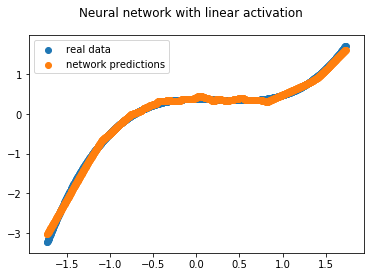

MSE: 0.0018462287381647215


In [219]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123, verbose=True)

# Multiple layers
nn.add_layer(100)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 8.784509539552815
loss on batch = 10.00073759006425
loss on batch = 10.110712653108408
loss on batch = 9.307908173714372
loss on batch = 7.647467997427143
loss on batch = 8.109716380915438
loss on batch = 9.677841429063744
loss on batch = 9.692893582744194
loss on batch = 5.440495567831115
loss on batch = 5.325140658283052
loss on batch = 7.5593076952721034
loss on batch = 6.496982752720719
loss on batch = 7.543557110101486
loss on batch = 6.2808077908770255
loss on batch = 4.927835871505411
loss on batch = 5.393185925066943
loss on batch = 6.410596017002141
loss on batch = 5.512538524891583
loss on batch = 4.249254236181491
loss on batch = 5.1608710282598445
loss on batch = 5.215850374893477
loss on batch = 4.551277668742635
loss on batch = 4.015072027403285
loss on batch = 4.9193642520519525
loss on batch = 3.691011162171966
loss on batch = 3.280620461654075
loss on batch = 4.6965395953834825
loss on batch = 4.527267801054984
loss on batch = 3.6750133855098355
loss on

loss on batch = 0.2857883182483379
loss on batch = 0.4221381788039497
loss on batch = 0.21236098990457453
loss on batch = 0.25384158558987396
loss on batch = 0.6136151170058851
loss on batch = 0.6886046701639589
loss on batch = 0.19303949377456184
loss on batch = 0.30830432223940296
loss on batch = 0.32847658475155256
loss on batch = 0.22891240626891765
loss on batch = 0.2221615587199499
loss on batch = 0.2777258174162027
loss on batch = 0.2130337198200967
loss on batch = 0.3864793598116955
loss on batch = 0.6609142949961431
loss on batch = 0.5637419522270186
loss on batch = 0.3185936548986382
loss on batch = 0.18098713900619512
loss on batch = 0.6090740444227793
loss on batch = 0.6215805149772484
loss on batch = 0.291909548986496
loss on batch = 0.4126282918342406
loss on batch = 0.6729047740588829
loss on batch = 0.34987826841761577
loss on batch = 0.3254631962508188
loss on batch = 0.3641192080158041
loss on batch = 0.2420849922604696
loss on batch = 0.25399133737656854
loss on batc

loss on batch = 0.20425985096818325
loss on batch = 0.19333370975870853
loss on batch = 0.201501123413843
loss on batch = 0.18205717937585725
loss on batch = 0.2313203053222152
loss on batch = 0.20563897399755984
loss on batch = 0.10159346934187347
loss on batch = 0.19821261396907564
loss on batch = 0.27714000763007635
loss on batch = 0.32120824662927105
loss on batch = 0.16893001201197563
loss on batch = 0.18643970166579496
loss on batch = 0.17425103977435094
loss on batch = 0.23395672524819686
loss on batch = 0.21429656433741998
loss on batch = 0.18459036520144834
loss on batch = 0.32527486705942193
loss on batch = 0.18470467906053506
loss on batch = 0.18878276817043246
loss on batch = 0.17096608179256215
loss on batch = 0.12269604340267558
loss on batch = 0.20660583742195598
loss on batch = 0.40921075277917573
loss on batch = 0.15400378164809503
loss on batch = 0.14728503290914513
loss on batch = 0.1946943722649991
loss on batch = 0.15548709125669488
loss on batch = 0.16180994955253

loss on batch = 0.18662781828000943
loss on batch = 0.21702039762495517
loss on batch = 0.027821316001008123
loss on batch = 0.17933036121009685
loss on batch = 0.1648934810364276
loss on batch = 0.17654805400812495
loss on batch = 0.1662065840373157
loss on batch = 0.10647023105899972
loss on batch = 0.22340501219787476
loss on batch = 0.3215885510487495
loss on batch = 0.19081603901554742
loss on batch = 0.14837367027028078
loss on batch = 0.1396859943887913
loss on batch = 0.19385644834037358
loss on batch = 0.1305970471355405
loss on batch = 0.2847000813060988
loss on batch = 0.19910051848567303
loss on batch = 0.14192357699626135
loss on batch = 0.18148128314408235
loss on batch = 0.14734249932773252
loss on batch = 0.17007770055758617
loss on batch = 0.1078712381605475
loss on batch = 0.19507455808087432
loss on batch = 0.1513158164525164
loss on batch = 0.23025427873518087
loss on batch = 0.15026423013522314
loss on batch = 0.3832232809640186
loss on batch = 0.23843637190009834


loss on batch = 0.1464341344205913
loss on batch = 0.2128588654524746
loss on batch = 0.252992501196754
loss on batch = 0.13265187275094453
loss on batch = 0.21851006473403492
loss on batch = 0.30088891225345016
loss on batch = 0.0834978423014553
loss on batch = 0.14299433278809703
loss on batch = 0.0952319648239815
loss on batch = 0.1542377743416931
loss on batch = 0.2379382513347231
loss on batch = 0.20407023088210788
loss on batch = 0.19726424669187292
loss on batch = 0.18256994760193626
loss on batch = 0.1909663042834319
loss on batch = 0.1632426676919614
loss on batch = 0.12656077229943496
loss on batch = 0.22818119911789417
loss on batch = 0.14906322574559966
loss on batch = 0.1881626158894686
loss on batch = 0.23071219570748042
loss on batch = 0.12182136438587576
loss on batch = 0.27206793343632435
loss on batch = 0.2351529492238506
loss on batch = 0.17436061237876407
loss on batch = 0.2338077725987587
loss on batch = 0.12830604070994642
loss on batch = 0.19105566900718424
loss 

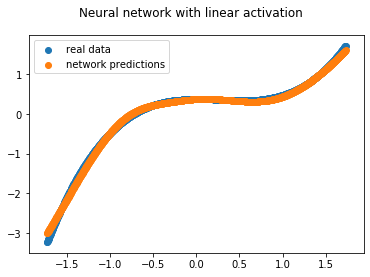

MSE: 0.0023589562746084195


In [220]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=True)

# Multiple layers
nn.add_layer(100)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=10, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

## Different loss functions

### Regression

In [223]:
data = pd.read_csv("projekt1/regression/data.cube.test.10000.csv")
X_train = np.array(data.iloc[:,:1])
y_train = np.array(data.iloc[:,1:])
data = pd.read_csv("projekt1/regression/data.cube.test.10000.csv")
X_test = np.array(data.iloc[:,:1])
y_test = np.array(data.iloc[:,1:])
X_test = (X_test - np.mean(X_train)) / np.std(X_train)
y_test = (y_test - np.mean(y_train)) / np.std(y_train)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
y_train = (y_train - np.mean(y_train)) / np.std(y_train)
print(X_train)
print(y_train)

array([-1,  0,  1])

loss on batch = 9.130365485483878
loss on batch = 8.346423007579927
loss on batch = 8.670153793880447
loss on batch = 8.605831728293648
loss on batch = 8.785031991682933
loss on batch = 8.194468627023936
loss on batch = 8.15024474302743
loss on batch = 7.986090636179996
loss on batch = 7.740531432256834
loss on batch = 8.787215491974099
loss on batch = 7.545334309877501
loss on batch = 8.7393575511689
loss on batch = 2.1930364461982226
loss on batch = 7.87685071854378
loss on batch = 7.134099838864684
loss on batch = 7.737844193882942
loss on batch = 7.370628185187932
loss on batch = 7.2002869363704205
loss on batch = 7.216421243002759
loss on batch = 7.472757766563284
loss on batch = 6.291883815109536
loss on batch = 5.94874594806642
loss on batch = 6.856297062311269
loss on batch = 6.912116027611343
loss on batch = 6.951030701827073
loss on batch = 2.0738010287435116
loss on batch = 5.851421308735676
loss on batch = 6.682185082908667
loss on batch = 6.433882271636156
loss on batch = 

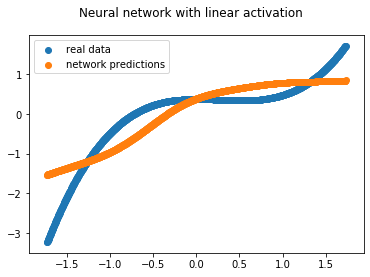

MSE: 0.22900569833132925


In [254]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=True, loss_function='mse')

# Multiple layers
nn.add_layer(10)
nn.add_layer(9)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=99, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 77.8877029169907
loss on batch = 67.81254122830465
loss on batch = 71.97871409427172
loss on batch = 71.09981208866843
loss on batch = 73.92958940613374
loss on batch = 65.04122369285386
loss on batch = 65.06279691107034
loss on batch = 63.75193887659957
loss on batch = 60.53683380557892
loss on batch = 72.36389538440493
loss on batch = 59.42818408475661
loss on batch = 73.15222846587015
loss on batch = 6.93372456647507
loss on batch = 64.87492591493009
loss on batch = 58.815059159425964
loss on batch = 64.75835542375494
loss on batch = 61.2338740708173
loss on batch = 58.849255065573814
loss on batch = 57.58550006254094
loss on batch = 61.84597388531749
loss on batch = 51.33947528377541
loss on batch = 49.45971894190718
loss on batch = 55.56849421430507
loss on batch = 58.47643077614733
loss on batch = 60.90844689570082
loss on batch = 6.612537620214206
loss on batch = 48.69806000951583
loss on batch = 52.35916836449367
loss on batch = 51.79439986356571
loss on batch =

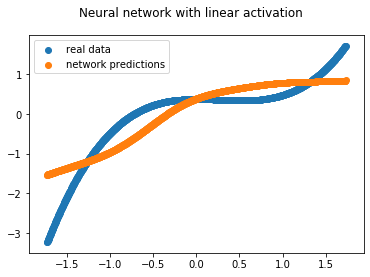

MSE: 0.22900569833132925


In [255]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123, verbose=True, loss_function='mae')

# Multiple layers
nn.add_layer(10)
nn.add_layer(9)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=10, batch_size=99, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

print("MSE: " + str(np.mean((pred - y_test)**2)))

### Classification

In [256]:
data = pd.read_csv("projekt1/classification/data.three_gauss.train.1000.csv")
X_train = np.array(data.iloc[:,:2])
y_train = np.array(data.iloc[:,2:])
data = pd.read_csv("projekt1/classification/data.three_gauss.test.1000.csv")
X_test = np.array(data.iloc[:,:2])
y_test = np.array(data.iloc[:,2:])
X_test = (X_test - np.mean(X_train)) / np.std(X_train)
# y_test = (y_test - np.mean(y_train)) / np.std(y_train)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
# y_train = (y_train - np.mean(y_train)) / np.std(y_train)
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train)
y_test = ohe.transform(y_test)
print(X_train)
print(y_train)

[[ 0.51839174  1.12942924]
 [ 0.54453533  2.16957697]
 [ 0.93212147  0.44372788]
 ...
 [-0.50272867  0.56045434]
 [ 0.17286364 -0.45026591]
 [ 0.49450439 -2.00396316]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


loss on batch = 20.04878439943373
loss on batch = 16.713483540922514
loss on batch = 13.7238139952461
loss on batch = 13.567617039608546
loss on batch = 12.836602840662431
loss on batch = 11.303991797767702
loss on batch = 9.719512850225108
loss on batch = 10.340468372783825
loss on batch = 10.603111962952491
loss on batch = 9.959685626464442
loss on batch = 10.480073895505573
loss on batch = 11.221202014306002
loss on batch = 10.710071018789334
loss on batch = 10.538955085268958
loss on batch = 9.966034884809796
loss on batch = 9.620704254988471
loss on batch = 8.429432594647567
loss on batch = 8.509930324692435
loss on batch = 9.81683967778412
loss on batch = 9.781076800787698
loss on batch = 8.880586561349688
loss on batch = 9.846459002868851
loss on batch = 9.419995959162486
loss on batch = 8.241336419242446
loss on batch = 9.437819805219295
loss on batch = 8.64857037800737
loss on batch = 7.517079885196612
loss on batch = 8.020674609945553
loss on batch = 8.475354246182489
loss on

loss on batch = 6.662590725023675
loss on batch = 8.345539856817688
loss on batch = 7.869669053469081
loss on batch = 6.873802194701715
loss on batch = 8.697029882213664
loss on batch = 6.9639455563946235
loss on batch = 7.522064588112729
loss on batch = 7.515024100285514
loss on batch = 6.399332018422681
loss on batch = 6.842581296441313
loss on batch = 6.159640478572101
loss on batch = 7.782649241286174
loss on batch = 6.95395505447364
loss on batch = 7.27709311024645
loss on batch = 6.583981894708118
loss on batch = 8.508269967071893
loss on batch = 7.9678627804311715
loss on batch = 8.238331000159512
loss on batch = 7.720617037604826
loss on batch = 6.455275349418668
loss on batch = 7.607056071927214
loss on batch = 8.034889902221831
loss on batch = 6.687972876472459
loss on batch = 8.476703905698031
loss on batch = 6.698278507931191
loss on batch = 6.585094302001932
loss on batch = 7.37975569914933
loss on batch = 6.9921702651409845
loss on batch = 8.606152082920051
loss on batch 

loss on batch = 5.820309763035664
loss on batch = 6.927654755021923
loss on batch = 6.981456129674719
loss on batch = 6.407759530143457
loss on batch = 8.413776635025284
loss on batch = 7.7191115386865015
loss on batch = 7.855123618734124
loss on batch = 7.116261354259058
loss on batch = 8.193936853575977
loss on batch = 7.439888103944867
loss on batch = 6.473561002353405
loss on batch = 7.241689111819393
loss on batch = 6.340326833165005
loss on batch = 7.05982287871734
loss on batch = 7.016863853381474
loss on batch = 6.078309945600597
loss on batch = 7.50964415752574
loss on batch = 7.6175966466069
loss on batch = 6.469937740328308
loss on batch = 7.17829132419151
loss on batch = 6.395393791622313
loss on batch = 8.058861784226721
loss on batch = 6.650991101896503
loss on batch = 6.293318011975376
loss on batch = 6.8906109649056635
loss on batch = 5.717232773207599
loss on batch = 6.822146169722924
loss on batch = 6.997857849054694
loss on batch = 6.101942832689106
loss on batch = 6

loss on batch = 5.94374795513164
loss on batch = 7.589068058981303
loss on batch = 6.9793367394843
loss on batch = 6.0108777067187855
loss on batch = 7.140518870465346
loss on batch = 5.669883672614106
loss on batch = 6.434143867377788
loss on batch = 7.176803523131156
loss on batch = 6.3733718891978
loss on batch = 6.697442437391618
loss on batch = 5.817125991791996
loss on batch = 6.607899797273042
loss on batch = 6.6180727743144265
loss on batch = 5.691460077542899
loss on batch = 6.557671641156137
loss on batch = 6.088206542982019
loss on batch = 5.919547645531217
loss on batch = 7.769784917901747
loss on batch = 7.57364616080404
loss on batch = 6.373771144454887
loss on batch = 6.029793930500703
loss on batch = 6.36735347841647
loss on batch = 5.653817752088856
loss on batch = 6.41055420627099
loss on batch = 8.2839143806792
loss on batch = 5.85308546222351
loss on batch = 6.503909983525286
loss on batch = 5.840612038623483
loss on batch = 5.93749933054591
loss on batch = 7.586185

loss on batch = 5.768957472331886
loss on batch = 6.004653933855066
loss on batch = 7.148309825331643
loss on batch = 5.91502563676152
loss on batch = 6.735486792042325
loss on batch = 7.561427888484375
loss on batch = 6.473878502327956
loss on batch = 7.007480423226178
loss on batch = 6.731790201781978
loss on batch = 6.986305009730604
loss on batch = 5.750149300518216
loss on batch = 5.817583482959375


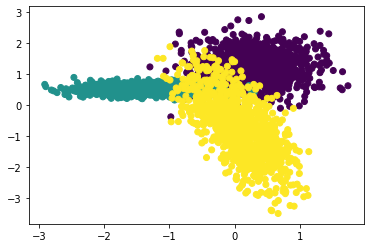

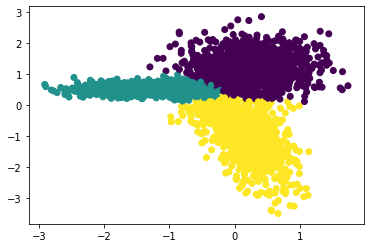

Acc: 0.9233333333333333


In [257]:
nn = NeuralNetwork(2, 3, activation_function="tanh", loss_function='crossentropy', seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer("softmax")
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(y_test, axis=1).flatten())
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(pred, axis=1).flatten())
plt.show()

print("Acc: " + str(np.mean((np.argmax(y_test, axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

loss on batch = 3.2797750097223126
loss on batch = 3.295548760316918
loss on batch = 3.028501435084235
loss on batch = 3.0386794124791625
loss on batch = 2.939945835421136
loss on batch = 2.8567138445208013
loss on batch = 2.724219455155948
loss on batch = 2.7050019491279738
loss on batch = 2.915271904927247
loss on batch = 2.8472329045763445
loss on batch = 2.8541670579738554
loss on batch = 2.7654999102268683
loss on batch = 2.6657727383230916
loss on batch = 2.654701462666568
loss on batch = 2.5675330521497943
loss on batch = 2.716367042544733
loss on batch = 2.582701330368418
loss on batch = 2.562154164017319
loss on batch = 2.6234801884817847
loss on batch = 2.5680850357051965
loss on batch = 2.5701696601514032
loss on batch = 2.615540437108877
loss on batch = 2.5933154581378286
loss on batch = 2.568599390858991
loss on batch = 2.554959074628121
loss on batch = 2.536992895797229
loss on batch = 2.574186393185178
loss on batch = 2.613196691806799
loss on batch = 2.5514950204888884


loss on batch = 2.3701179158416283
loss on batch = 2.1517609336489096
loss on batch = 2.323958754612953
loss on batch = 2.106381179391689
loss on batch = 2.329923118288441
loss on batch = 2.2419244195153163
loss on batch = 2.1239430101015047
loss on batch = 2.2575693008764075
loss on batch = 2.133540695863704
loss on batch = 2.1338563501689634
loss on batch = 2.4557959846405084
loss on batch = 2.184626176293287
loss on batch = 2.033439132384132
loss on batch = 2.184624115964311
loss on batch = 2.3650007591118767
loss on batch = 1.9186041648585164
loss on batch = 2.2256229144643314
loss on batch = 1.9342152865123097
loss on batch = 2.1283560833767097
loss on batch = 2.3835907833564423
loss on batch = 2.370928880093349
loss on batch = 2.191150333031717
loss on batch = 2.3220745943621925
loss on batch = 2.163742196506149
loss on batch = 2.3343913280082202
loss on batch = 2.063520562774959
loss on batch = 2.036304095626599
loss on batch = 2.1813712725569476
loss on batch = 2.18084427691049

loss on batch = 2.147718608818987
loss on batch = 2.0592680631218796
loss on batch = 1.9694608174919337
loss on batch = 1.9308430869426054
loss on batch = 2.14503523833787
loss on batch = 2.1302068785076993
loss on batch = 1.898149366663223
loss on batch = 2.0153044967632208
loss on batch = 1.811697716994772
loss on batch = 2.003803082950364
loss on batch = 1.941480137910035
loss on batch = 1.9798583061208406
loss on batch = 2.0965766992048955
loss on batch = 2.0110697741449384
loss on batch = 1.944791292989004
loss on batch = 2.0447165683605895
loss on batch = 2.0349100404296223
loss on batch = 2.156795385161449
loss on batch = 1.902949142305035
loss on batch = 1.8621560786850448
loss on batch = 1.992275304637595
loss on batch = 1.8455765423366717
loss on batch = 2.0141548985219733
loss on batch = 2.1020259658468823
loss on batch = 1.8691097088560764
loss on batch = 1.9179140730801851
loss on batch = 1.8936162531202199
loss on batch = 1.934532565914605
loss on batch = 2.05754362924652

loss on batch = 1.9025987012626455
loss on batch = 1.71280041014394
loss on batch = 1.7499453719009432
loss on batch = 1.7031434606654574
loss on batch = 1.965850684284541
loss on batch = 1.8008775001633266
loss on batch = 2.1024426607509854
loss on batch = 1.8957640710090247
loss on batch = 1.8716285103244217
loss on batch = 1.8008707110288755
loss on batch = 1.7835191809822535
loss on batch = 1.7718917290576888
loss on batch = 2.077287065981635
loss on batch = 1.7945812675615986
loss on batch = 1.9378225888241287
loss on batch = 1.7422486117179232
loss on batch = 1.7210760278807131
loss on batch = 1.963674470603329
loss on batch = 1.775739608152186
loss on batch = 2.1002047069185314
loss on batch = 1.8598882324712762
loss on batch = 2.081020871138748
loss on batch = 1.9268350500823732
loss on batch = 2.2289027613058447
loss on batch = 1.7149517197340047
loss on batch = 1.7507665046862981
loss on batch = 1.9794470771732584
loss on batch = 1.866931491886775
loss on batch = 1.7526351110

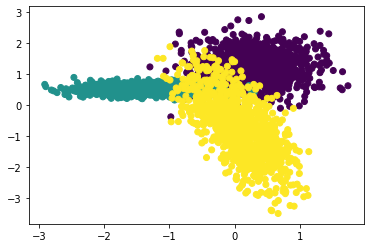

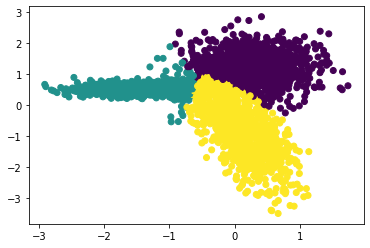

Acc: 0.9206666666666666


In [258]:
nn = NeuralNetwork(2, 3, activation_function="tanh", loss_function='mse', seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer("softmax")
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(y_test, axis=1).flatten())
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(pred, axis=1).flatten())
plt.show()

print("Acc: " + str(np.mean((np.argmax(y_test, axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

loss on batch = 16.376891731468003
loss on batch = 16.330312156134298
loss on batch = 15.189469118756081
loss on batch = 15.171702253440307
loss on batch = 15.025127774464691
loss on batch = 14.655451914785939
loss on batch = 13.970610788318245
loss on batch = 13.884251155821476
loss on batch = 14.623450306010517
loss on batch = 14.508716415487637
loss on batch = 14.412309603915185
loss on batch = 13.989764355383876
loss on batch = 13.571816926846177
loss on batch = 13.496825498939716
loss on batch = 13.120980424179585
loss on batch = 13.865932336324414
loss on batch = 13.277541696625555
loss on batch = 13.141848088792848
loss on batch = 13.289366127212173
loss on batch = 13.138338384268666
loss on batch = 13.196823367908724
loss on batch = 13.378857335940918
loss on batch = 13.303344022848357
loss on batch = 13.196054857545093
loss on batch = 13.130255490664968
loss on batch = 13.034692616553084
loss on batch = 13.194444193859471
loss on batch = 13.42091595414015
loss on batch = 13.13

loss on batch = 11.407920026445595
loss on batch = 12.105612461345533
loss on batch = 10.909080787143791
loss on batch = 11.910627552783394
loss on batch = 10.673462600232966
loss on batch = 11.872474958288507
loss on batch = 11.410559570673115
loss on batch = 10.671867600497489
loss on batch = 11.41252903552677
loss on batch = 10.795443974064083
loss on batch = 10.812649488967038
loss on batch = 12.557422305683156
loss on batch = 11.085051740471163
loss on batch = 10.386430126956451
loss on batch = 11.043122199563879
loss on batch = 12.031394038059531
loss on batch = 9.702948473386577
loss on batch = 11.159350593598694
loss on batch = 9.769052604030646
loss on batch = 10.820587235166045
loss on batch = 12.132871750889025
loss on batch = 12.051386320576022
loss on batch = 11.1381193141261
loss on batch = 11.82774195127461
loss on batch = 10.954867569632949
loss on batch = 11.890435657643769
loss on batch = 10.47702481844583
loss on batch = 10.329698298200249
loss on batch = 10.97882940

loss on batch = 9.825685624906805
loss on batch = 10.05376834896794
loss on batch = 9.994137033727153
loss on batch = 9.259142486225551
loss on batch = 9.395426167476868
loss on batch = 10.805731513963234
loss on batch = 10.374685494307963
loss on batch = 9.962093150066396
loss on batch = 10.759182883414985
loss on batch = 10.421297806109555
loss on batch = 10.022870429256532
loss on batch = 9.819892016502763
loss on batch = 10.82880813299635
loss on batch = 10.80654072974304
loss on batch = 9.757210429711048
loss on batch = 10.252129432264246
loss on batch = 9.26341046438857
loss on batch = 10.156873554916071
loss on batch = 9.853417741938596
loss on batch = 10.081403184867934
loss on batch = 10.707992338989053
loss on batch = 10.058699116771585
loss on batch = 9.852929080301232
loss on batch = 10.342036166847745
loss on batch = 10.388131829562226
loss on batch = 10.92737033125513
loss on batch = 9.7299823383537
loss on batch = 9.533678765034443
loss on batch = 10.175882852137349
loss

loss on batch = 9.56769091681813
loss on batch = 8.700415305289447
loss on batch = 8.78524875129229
loss on batch = 9.634934456476644
loss on batch = 8.78910812638772
loss on batch = 8.951338794625851
loss on batch = 8.75113515794436
loss on batch = 9.89902932633594
loss on batch = 9.247484172067889
loss on batch = 10.567090056130201
loss on batch = 9.497490958970209
loss on batch = 9.564995725134715
loss on batch = 9.14895654503108
loss on batch = 9.137390087080801
loss on batch = 9.028743654005964
loss on batch = 10.483254187420918
loss on batch = 9.104691927396257
loss on batch = 9.80824149857084
loss on batch = 8.900223725101654
loss on batch = 8.776072099449962
loss on batch = 9.859796845592417
loss on batch = 8.876068591253839
loss on batch = 10.491033914293073
loss on batch = 9.510612116411044
loss on batch = 10.339468285876476
loss on batch = 9.662620606272878
loss on batch = 11.235632694070311
loss on batch = 8.782092147329502
loss on batch = 8.997121053537875
loss on batch = 

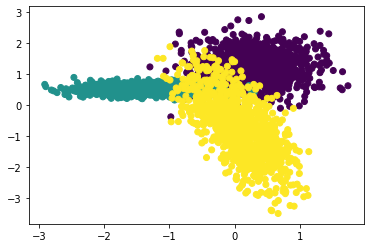

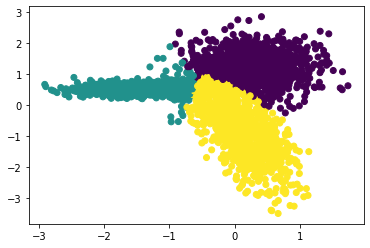

Acc: 0.9206666666666666


In [259]:
nn = NeuralNetwork(2, 3, activation_function="tanh", loss_function='mae', seed=123, verbose=True)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer("softmax")
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(y_test, axis=1).flatten())
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c = np.argmax(pred, axis=1).flatten())
plt.show()

print("Acc: " + str(np.mean((np.argmax(y_test, axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))